In [4]:
# SETUP
# load all packages and read in most all data for this notebook
library(raster)
library(data.table)
library(ggplot2)
library(lubridate)

wdata <- fread('wdata.csv') # historical, site-specific weather data downloaded from gridMet
generatedAnomData <- readRDS('ExampleData/generatedAnomData') # generated anomalies at the lead-level
MonthlyAnoms <- fread('ExampleData/MonthlyAnoms.csv') # anomalies averaged to the monthly level

HistDataNormMean <- fread('ExampleData/HistDataNormMean.csv') # Summarized temperature and soil moisture values for the historical normal period (1981 - 2010)
AnomRunStats <- fread('ExampleData/AnomRunStats.csv') #Summarize temperature and soil moisture values for the future period

source('functions/weatherFunctions.R') 
currMonth <- month(Sys.Date())
Nleads <- 12


Loading required package: sp


Attaching package: ‘data.table’


The following object is masked from ‘package:raster’:

    shift



Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following object is masked from ‘package:base’:

    date




# Introduction

The intention of the short-term drought forecaster (STDF) is to predict weather and soil moisture for the upcoming year at a fine temporal and spatial scale.

The Climate Prediction Center (CPC) of the National Weather Service (NWS) provides “long-lead” outlooks for temperature and precipitation for 102 regions in the lower 48 of the United States.

![image](images/Screen Shot 2020-05-03 at 6.40.01 PM.png)

These outlooks consist of the probability of whether a region will be hotter or cooler (temperature) and wetter or drier (precipitation) than their 30-year climatological normal (1980-2010) for 1 1-month and 13 3-month outlooks. These outlooks are updated on the 15th of each month and the 1-month outlook is for the nearest upcoming month while the 3-month outlooks consist of 13 total forecasts for the next year. The 3-month outlooks overlap one another, and each individual month is included in up to 3 outlooks. For example, on May 15th, the closest 1-month outlook would be for June, and the nearest 3-month outlook would be for June-July-August. There are subsequent outlooks for July-August-September, August-September-October, and so on for the next 13 month period.

![image](https://www.cpc.ncep.noaa.gov/products/predictions/multi_season/13_seasonal_outlooks/color/page2.gif)

# National Weather Service Forecasts

The NWS uses "probability of exceedance" curves to give the forecast probability that a temperature or precipitation quantity will be exceeded at the location in question, for the forecast period. 

[temperature probability of exceedence curve](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/poe_graph_index.php?lead=1&climdiv=97&var=t)

[precipitation probability of exceedence curve](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/poe_graph_index.php?lead=1&climdiv=97&var=p)

In addition to the probability of exceedance, a ‘point forecast’ is given for the mean forecasted anomaly and the standard deviation (SD) of that anomaly, as well as percentile (%ile) that this mean will exceed the climatological mean (top left corners of the above figures). These probability of exceedance curves are generated for each outlook and region and are the basis for the information we see in the maps above. NWS meteorologists makes these forecasts using a series of models and tools that evaluate historical patterns as well as current global atmospheric and oceanic patterns. Full discussion [here](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/tools.php).

Our intent with the short-term forecaster is to translate the information from the NWS CPC into predictions that are fine-tuned for specific locations, instead of the broad outlooks provided for 102 regions. In addition, we translate these predictions to a finer temporal scale, so we are able to utilize them as the climate driver in in a daily driven, water-balance model, SOILWAT2. SOILWAT2 is a site-specific model, that takes inputs about daily weather, vegetation, and soils (multi-layer), and mechanistically predicts daily soil moisture, a metric used for evaluating likely success of plant germination and survival.

# Downscaling Methods

First, for each set of coordinates, the appropriate region is determined from the map above and the affiliated temperature and precipitation NWS long-lead forecast data are grabbed. Temperature and precipitation data are stored online in tabular form, [here](https://www.cpc.ncep.noaa.gov/pacdir/NFORdir/HUGEdir2/cpcllftd.dat) and [here](https://www.cpc.ncep.noaa.gov/pacdir/NFORdir/HUGEdir2/cpcllfpd.dat).


In [24]:
# Set coordinates
lat <- 35.1266
lng <- -111.5854

# Determine Region from coordinates and shapefile ------------------------------------------
CD102 <- shapefile(x = 'CD102/CD102.shp')
points <- data.frame(x = lng, y = lat)

coordinates(points) <- ~ x + y 
proj4string(points) <- CRS("+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0")

CDRegion <- as.numeric(over(points, CD102)$ID4)

# Read in and subset anomaly data -----------------------------------------------------------
TempAnomsWhole <- fread('CurrentAnomalyTempData.csv') # this data is downloaded from the NWS website
TempAnoms <- subset(TempAnomsWhole, CD == CDRegion)
TempAnoms <- TempAnoms[1:Nleads, ]

PPTAnomsWhole <- fread('CurrentAnomalyPPTData.csv') # this data is downloaded from the NWS website
PPTAnoms <- subset(PPTAnomsWhole, CD == CDRegion)
PPTAnoms <- PPTAnoms[1:Nleads, ]

# Convert values and calculate NWS anomalies or correction factors \-------------------------------------------
  
# Temp
TempAnoms$ClimatologicalMEAN_Temp_C <- (TempAnoms$ClimatologicalMEAN - 32) * (5/9)
TempAnoms$ForecastedMEAN_Temp_C <- (TempAnoms$ForecastedMEAN - 32) * (5/9)
  
TempAnoms$ForecastedSD_Temp_C <- (TempAnoms$ForecastedSD) * (5/9)
TempAnoms$Anom_F <- TempAnoms$ForecastedMEAN - TempAnoms$ClimatologicalMEAN
TempAnoms$Anom_C <- TempAnoms$Anom_F * (5/9)
  
# PPT - keep in transformed units for calcs downstream
## PPT - SDs are given in transformed units. Means are in inches. 
backT <- 1/PPTAnoms$PO

# convert
PPTAnoms$ClimatatologicalMEAN_PPT_PO <- PPTAnoms$ClimatologicalMEAN ^ PPTAnoms$PO
PPTAnoms$ClimatatologicalMEAN_PPT_cm <- PPTAnoms$ClimatologicalMEAN * 2.54
  
PPTAnoms$ForecastedMEAN_PPT_PO <- PPTAnoms$ForecastedMEAN ^ PPTAnoms$PO
PPTAnoms$ForecastedMEAN_PPT_cm <- PPTAnoms$ForecastedMEAN * 2.54
  
PPTAnoms$ForecastedSD_PPT_in <- as.numeric(PPTAnoms$ForecastedSD) ^ backT
PPTAnoms$ForecastedSD_PPT_cm <- PPTAnoms$ForecastedSD_PPT_in * 2.54
  
# calc - anomaly NEEDS to be calcualted in transformed units
PPTAnoms$Anom_PO <- PPTAnoms$ForecastedMEAN_PPT_PO - PPTAnoms$ClimatatologicalMEAN_PPT_PO
PPTAnoms$Anom_cm_MEAN <- PPTAnoms$ForecastedMEAN_PPT_cm - PPTAnoms$ClimatatologicalMEAN_PPT_cm
PPTAnoms$Anom_CF_MEAN <- PPTAnoms$ForecastedMEAN / PPTAnoms$ClimatologicalMEAN
  
# generate precipitation climatological median by sampling climatological populations mean and sd in transformed units
ClimatologicalPPTByLead <- PPTAnoms[,.(vals = rnorm(1000, mean = ClimatatologicalMEAN_PPT_PO, sd = ClimatologicalSD)), .(LEAD, PO)]
ClimatologicalPPTByLead$vals_in <- ClimatologicalPPTByLead$vals ^ (backT)
ClimatologicalPPTByLead$vals_cm <- ClimatologicalPPTByLead$vals_in * 2.54
ClimatologicalMedianByLead <- ClimatologicalPPTByLead[,.(ClimatatologicalMEDIAN_PPT_cm = median(vals_cm)), .(LEAD)]

PPTAnoms$ClimatatologicalMEDIAN_PPT_cm <- ClimatologicalMedianByLead$ClimatatologicalMEDIAN_PPT_cm
PPTAnoms$Anom_cm_MEDIAN <- PPTAnoms$ForecastedMEAN_PPT_cm - PPTAnoms$ClimatatologicalMEDIAN_PPT_cm
PPTAnoms$Anom_CF_MEDIAN <- PPTAnoms$ForecastedMEAN_PPT_cm / PPTAnoms$ClimatatologicalMEDIAN_PPT_cm


print('NWS Temperature Data')
TempAnoms
print('NWS Precipitation Data')
PPTAnoms

[1] "NWS Temperature Data"


YEAR MN LEAD CD ForecastedMEAN ClimatologicalMEAN ForecastedSD
1  2020 5   1   97 70.97          69.98              1.2039      
2  2020 5   2   97 69.64          68.80              1.0297      
3  2020 5   3   97 63.00          62.12              1.0835      
4  2020 5   4   97 53.41          52.51              1.2727      
5  2020 5   5   97 43.42          42.38              1.3283      
6  2020 5   6   97 36.88          35.83              1.6065      
7  2020 5   7   97 35.00          34.40              1.8439      
8  2020 5   8   97 38.35          37.68              1.6754      
9  2020 5   9   97 44.15          43.17              1.5151      
10 2020 5  10   97 50.73          50.22              1.8356      
11 2020 5  11   97 58.91          58.37              1.8835      
12 2020 5  12   97 66.95          65.99              1.5450      
   ClimatologicalSD ClimatologicalMEAN_Temp_C ForecastedMEAN_Temp_C
1  1.35             21.100000                 21.650000            
2  1.14             20.444444                 20.911111            
3  1.19             16.733333                 17.222222            
4  1.40             11.394444                 11.894444            
5  1.44              5.766667                  6.344444            
6  1.64              2.127778                  2.711111            
7  1.92              1.333333                  1.666667            
8  1.76              3.155556                  3.527778            
9  1.56              6.205556                  6.750000            
10 1.91             10.122222                 10.405556            
11 2.07             14.650000                 14.950000            
12 1.68             18.883333                 19.416667            
   ForecastedSD_Temp_C Anom_F Anom_C   
1  0.6688333           0.99   0.5500000
2  0.5720556           0.84   0.4666667
3  0.6019444           0.88   0.4888889
4  0.7070556           0.90   0.5000000
5  0.7379444           1.04   0.5777778
6  0.8925000           1.05   0.5833333
7  1.0243889           0.60   0.3333333
8  0.9307778           0.67   0.3722222
9  0.8417222           0.98   0.5444444
10 1.0197778           0.51   0.2833333
11 1.0463889           0.54   0.3000000
12 0.8583333           0.96   0.5333333

[1] "NWS Precipitation Data"


YEAR MN LEAD CD ForecastedMEAN ClimatologicalMEAN ForecastedSD
1  2020 5   1   97 4.72           4.72               0.3000      
2  2020 5   2   97 5.89           5.89               0.4800      
3  2020 5   3   97 5.22           5.20               0.5051      
4  2020 5   4   97 3.72           3.66               0.2998      
5  2020 5   5   97 3.74           3.33               0.2481      
6  2020 5   6   97 3.30           3.30               0.2400      
7  2020 5   7   97 3.86           3.42               0.2306      
8  2020 5   8   97 3.86           3.68               0.2296      
9  2020 5   9   97 3.28           3.27               0.4000      
10 2020 5  10   97 2.54           2.49               0.3578      
11 2020 5  11   97 1.43           1.43               0.2000      
12 2020 5  12   97 2.76           2.76               0.3600      
   ClimatologicalSD PO   ClimatatologicalMEAN_PPT_PO ⋯ ForecastedMEAN_PPT_PO
1  0.30             0.49 2.139102                    ⋯ 2.139102             
2  0.48             0.61 2.949649                    ⋯ 2.949649             
3  0.51             0.68 3.068190                    ⋯ 3.076210             
4  0.30             0.40 1.680322                    ⋯ 1.691286             
5  0.25             0.28 1.400504                    ⋯ 1.446785             
6  0.24             0.27 1.380380                    ⋯ 1.380380             
7  0.24             0.25 1.359899                    ⋯ 1.401673             
8  0.23             0.28 1.440248                    ⋯ 1.459636             
9  0.40             0.51 1.829866                    ⋯ 1.832718             
10 0.36             0.48 1.549443                    ⋯ 1.564300             
11 0.20             0.29 1.109296                    ⋯ 1.109296             
12 0.36             0.54 1.730178                    ⋯ 1.730178             
   ForecastedMEAN_PPT_cm ForecastedSD_PPT_in ForecastedSD_PPT_cm Anom_PO    
1  11.9888               0.085684155         0.217637755         0.000000000
2  14.9606               0.300223478         0.762567633         0.000000000
3  13.2588               0.366260638         0.930302021         0.008019568
4   9.4488               0.049212913         0.125000799         0.010964782
5   9.4996               0.006885773         0.017489865         0.046281068
6   8.3820               0.005063911         0.012862334         0.000000000
7   9.8044               0.002827725         0.007182422         0.041774783
8   9.8044               0.005221036         0.013261433         0.019387234
9   8.3312               0.165853818         0.421268697         0.002851785
10  6.4516               0.117512491         0.298481728         0.014857206
11  3.6322               0.003888290         0.009876256         0.000000000
12  7.0104               0.150777995         0.382976108         0.000000000
   Anom_cm_MEAN Anom_CF_MEAN ClimatatologicalMEDIAN_PPT_cm Anom_cm_MEDIAN
1  0.0000       1.000000     14.778518                      -2.7897184   
2  0.0000       1.000000     31.666267                     -16.7056673   
3  0.0508       1.003846     34.476802                     -21.2180016   
4  0.1524       1.016393      8.293435                       1.1553648   
5  1.0414       1.123123      5.660847                       3.8387528   
6  0.0000       1.000000      5.475388                       2.9066122   
7  1.1176       1.128655      5.445930                       4.3584697   
8  0.4572       1.048913      5.864758                       3.9396416   
9  0.0254       1.003058     10.885374                      -2.5541744   
10 0.1270       1.020080      7.074533                      -0.6229331   
11 0.0000       1.000000      3.263748                       0.3684519   
12 0.0000       1.000000      9.132443                      -2.1220433   
   Anom_CF_MEDIAN
1  0.8112315     
2  0.4724460     
3  0.3845716     
4  1.1393108     
5  1.6781234     
6  1.5308505     
7  1.8003168     
8  1.6717483     
9  0.7653572     
1

Note: Long-lead forecasts are predictions for rolling 3-month long windows. Temperature values (C) are means across 3-month windows and precipitation values (inches) are sums. For example, a Lead of 1, refers to the months of June-July-August, Lead 2 refers to July-August-September, and so on and so forth. In order to correctly predict monthly values from the lead data we need to look at what leads are affiliated with each month. To switch between leads and months, we create a monthLeads table.

In [11]:
print("Months & Leads Table")

monthLeads <- makeMonthLeadRelationshipTable(TempAnoms)
monthLeads


[1] "Months & Leads Table"


LEAD Month lead1 lead2 lead3
1   1    7     1    NA    NA   
2   2    8     2     1    NA   
3   3    9     3     2     1   
4   4   10     4     3     2   
5   5   11     5     4     3   
6   6   12     6     5     4   
7   7    1     7     6     5   
8   8    2     8     7     6   
9   9    3     9     8     7   
10 10    4    10     9     8   
11 11    5    11    10     9   
12 12    6    12    11    10

Next, because the future forecast for each lead are probability curves of potential values we want to create a numerical distribution of potential futures using the NWS data. To accomplish this, we use multivariate sampling that considers the covariance between historical temperature and precipitation anomalies, as well as the NWS forecast for the mean and standard deviation in the coming months. 

For these broad forecasts to reflect site-specific climatology we apply these regional anomalies to site-specific historical data. Specifically, for a point location (lat, long) historical weather data (1980 – current) is downloaded from [gridMet](http://www.climatologylab.org/gridmet.html), a daily, high-spatial resolution surface meteorological dataset, using the geoknife package.

To create our sample, we first calculate monthly mean temperature and the monthly sum of precipitation for each month in a 30 year climatic normal period (1981 - 2020). Then, using the roll apply function, we mean and sum these monthly values to their affiliated NWS lead. The difference between the NWS lead and historical lead data is calculated, to create an array of meteorological anomalies. The covariance between the lead anomaly values is then calculated in order to apply multivariate sampling. The multivariate sample considerrs each lead period and looks at covariance, the forecasted standard deviation, and the forecasted anomaly. All precipitation calculations are performed in transformed units.

We would expect these generated anomaly values to have the same mean, standard deviation, and covariance structure as our dataset. Below we are looking at a sample set of anomalies (n = 100)

[,1]       [,2]        [,3]        [,4]       [,5]      [,6]      
 [1,]  0.4219583  0.82787882  2.40625595  0.2027278 0.1613886  0.2190060
 [2,]  0.6650276  0.84255328  0.46042317  0.5922554 1.1373707 -0.3157631
 [3,] -0.5597935  0.83437693 -0.38800504  0.3677951 1.1788037 -0.1211058
 [4,]  0.3934326  1.79544625  1.03759817 -0.4503438 0.1049727 -1.0177275
 [5,]  1.1011585  1.22760663  1.26011620  0.5827928 0.2832971  0.4499196
 [6,]  0.2222422  0.75279794  0.08185678  0.6676465 0.6940309  0.2333250
 [7,]  0.6393755  1.17814647  0.62165353  2.0466202 1.4327291  0.5791730
 [8,]  0.3836338 -0.03287163  2.56454402 -0.5134793 2.4785441 -0.1250733
 [9,]  1.0467303  1.03007279  0.21630022 -1.6502085 1.1824568  1.0757863
[10,] -1.1430353  0.41172229  0.89421369 -0.1825371 0.9111518 -0.9770017
[11,]  1.3794221  1.09459771  0.15818535  0.7498539 1.3592217  0.8699604
[12,]  0.6792517  0.85411963  0.62284576  1.0917809 0.2147651  1.5216357
      [,7]        [,8]        [,9]        [,10]      [,11] [,12]     
 [1,] -0.61952322  0.98121059 -0.23212019  0.8846300 ⋯      0.1924152
 [2,]  0.40126215  0.96632705 -0.68518691 -0.9774436 ⋯      0.9604471
 [3,] -0.80595310  1.07578507  0.30690767  1.1527492 ⋯      0.3017778
 [4,]  0.34763337  0.56020025  0.62484783  1.0257237 ⋯      0.7204295
 [5,] -0.05849768  0.27185656  1.05287227  0.8330752 ⋯      1.1218699
 [6,] -0.10581399 -0.90626946  1.33274596 -0.1728663 ⋯      1.2850663
 [7,]  0.48521195  3.24925087  0.76659377 -0.1203292 ⋯     -1.0927475
 [8,]  0.89796722 -1.18601122  2.26780365  1.1725181 ⋯      0.9845466
 [9,]  0.20531769  1.26939198  1.37220493  1.5245760 ⋯      1.4196395
[10,]  1.17449164 -0.46114520  0.05726634 -0.2834319 ⋯      2.0773974
[11,]  0.16811258  0.07896133  0.59782245  0.5270204 ⋯      0.5947359
[12,]  0.63294375  0.94771395  1.40942561  0.6824367 ⋯     -0.6353498
      [,13]      [,14]      [,15]       [,16]      [,17]       [,18]     
 [1,]  1.0876602  0.5245612 -0.14304080  1.3930193  0.53166795  0.8467870
 [2,]  1.2722050  1.0484587  1.42035505  0.1895862  0.03178863  0.6226841
 [3,]  1.2885826  0.6180785  0.38883414  0.5783436  1.09760851  0.4902216
 [4,]  0.4606432  0.7749096  0.01735135 -0.4460365 -0.10289267  1.6578267
 [5,]  1.0391570  0.6359133  0.62257230  0.8532248 -0.72921871  1.0188036
 [6,]  1.2476766  0.7533059  0.84116299  0.9763639  0.83172591  0.8694759
 [7,]  0.4799375  0.4099610 -0.42857203 -0.2872035  1.14588098 -0.2472058
 [8,] -0.4537005 -0.6624875  2.23905564  1.3848089 -0.98099792  0.2251980
 [9,]  1.6361545  0.2027682  0.09727353  0.8267682  0.16618264 -0.0677588
[10,]  0.6574383  1.1954010  0.77601523 -2.0054246 -0.23975372 -1.0304741
[11,]  1.0705069  1.2648850 -0.48790453 -2.2085072  0.75739414  1.1595276
[12,]  1.0848902 -0.2222431  0.87241423  1.1988162  0.09801588 -0.8852533
      [,19]       [,20]       [,21]       
 [1,]  0.51777790  0.24176944 -0.004488835
 [2,] -0.65618395 -0.34824861  0.967176027
 [3,]  0.84196594  0.54688984  0.885293131
 [4,]  0.90516260 -0.06081334 -0.329391532
 [5,]  1.92620161  0.96717542  1.646998219
 [6,] -0.27861233  0.45473439 -1.714578764
 [7,] -0.20939425 -0.67978460 -1.432203051
 [8,] -0.09954786  2.46980544 -0.853177162
 [9,]  0.84924675  0.86621051  0.712376680
[10,]  0.99762150 -0.96635131  0.065452127
[11,]  0.86136935  0.09259433  1.807669710
[12,]  1.25532160 -2.80655195  1.383307805

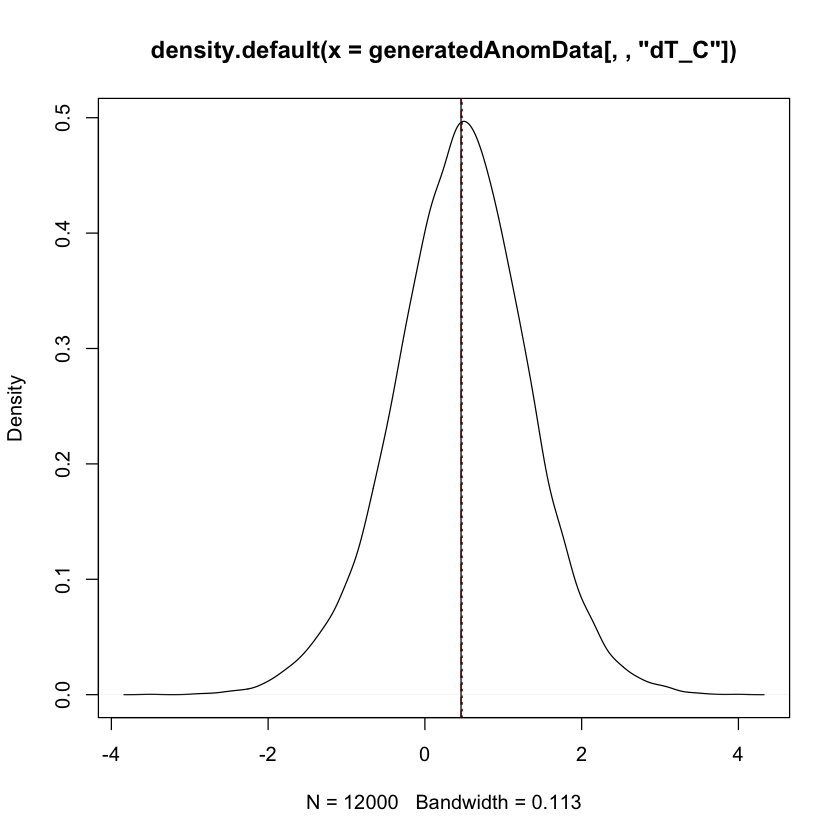

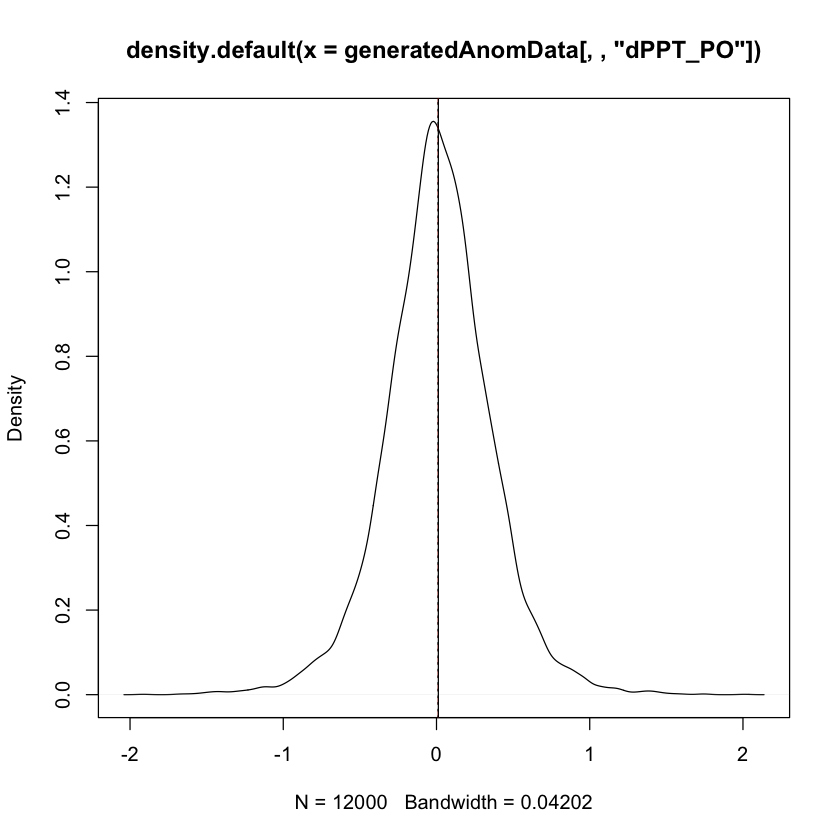

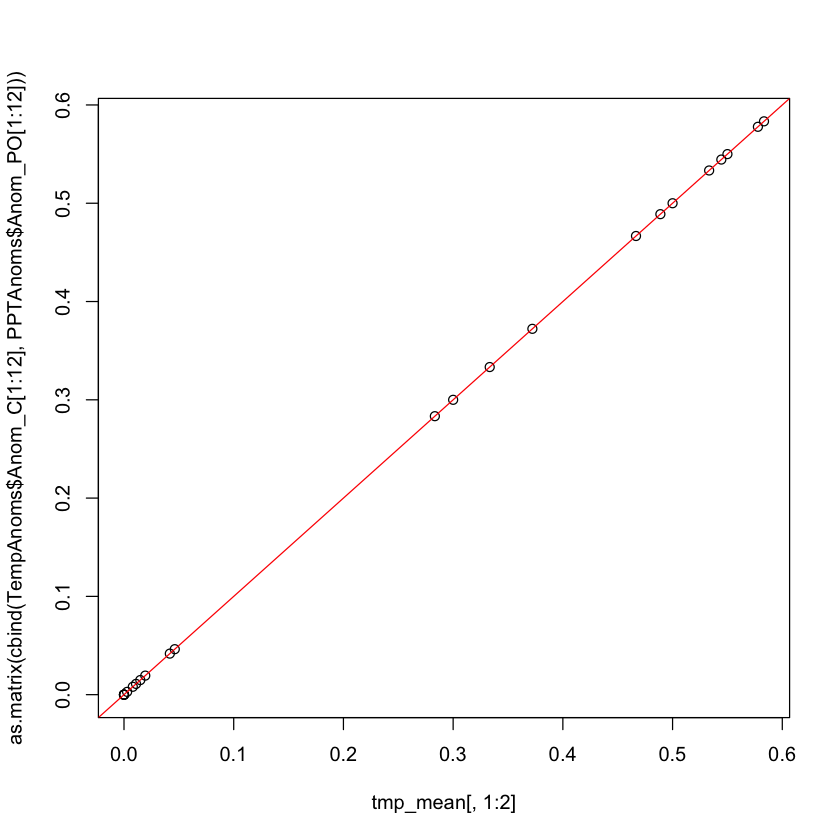

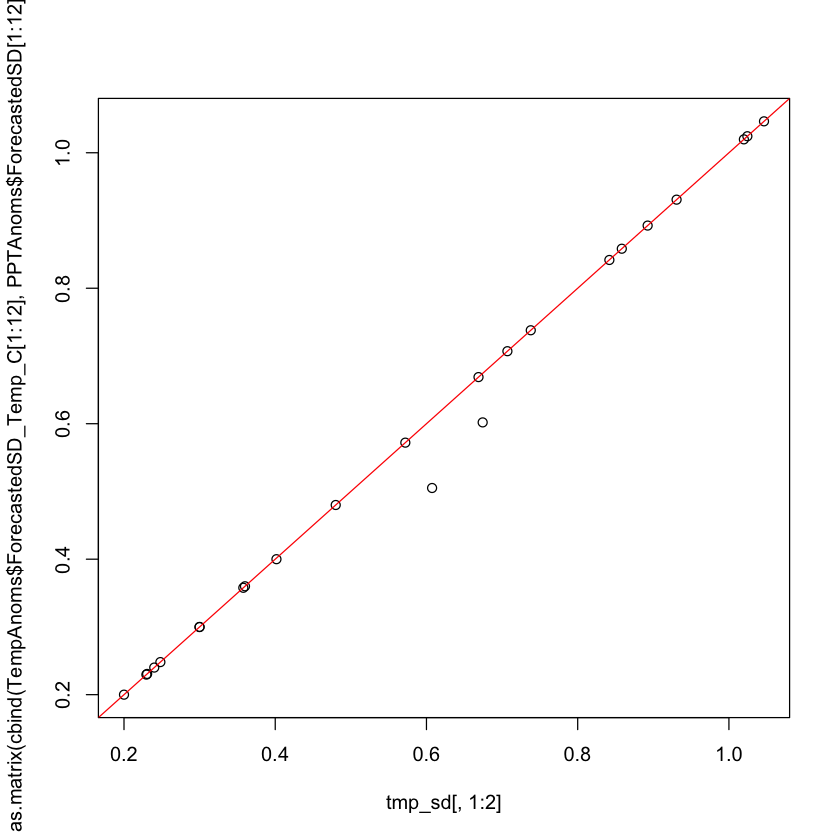

In [12]:
# function to create anomaly data - for now we will look at saved data
# generatedAnomData <- generateAnomalyData(monthlyWdata, TempAnoms, PPTAnoms, 
#                                         leads = seq_len(Nleads), Nleads = Nleads, 
#                                         n = n)



# Check that means have no bias compared to forecasted NWS means
generatedAnomData[, , "dT_C"]
plot(density(generatedAnomData[, , "dT_C"]))
abline(v = mean(TempAnoms$Anom_C), col = "red", lty = 2)
abline(v = mean(generatedAnomData[, , "dT_C"]))
abline(v = median(generatedAnomData[, , "dT_C"]), lty = 3)

plot(density(generatedAnomData[, , "dPPT_PO"]))
abline(v = mean(PPTAnoms$Anom_PO), col = "red", lty = 2)
abline(v = mean(generatedAnomData[, , "dPPT_PO"]))
abline(v = median(generatedAnomData[, , "dPPT_PO"]), lty = 3)


# Check that means have no bias compared to forecasted NWS means
tmp_mean <- apply(
  X = generatedAnomData,
  MARGIN = c(1,3),
  FUN = mean
)

plot(
  tmp_mean[,1:2],
  as.matrix(cbind(TempAnoms$Anom_C[1:12], PPTAnoms$Anom_PO[1:12]))
)
abline(0, 1, col = "red")


# Check that SDs have no bias compared to forecasted NWS SDs
tmp_sd <- apply(
  X = generatedAnomData,
  MARGIN = c(1,3),
  FUN = sd
)

plot(
  tmp_sd[,1:2],
  as.matrix(cbind(TempAnoms$ForecastedSD_Temp_C[1:12], PPTAnoms$ForecastedSD[1:12]))
)
abline(0, 1, col = "red")

# TO do - add covariances.

## Temperature

### Leads -  Generated lead anomaly data vs. NWS lead forecasts

[1] "Density plots of predicted LEAD Anomalies"


LEAD UVNWSmean LEAD MVGenmean LEAD AnalyticalMean NWS_Anom 
1   1   0.5530757 1    0.5500000  1   0.5500000      0.5500000
2   2   0.4587871 2    0.4666667  2   0.4666667      0.4666667
3   3   0.5054505 3    0.4888889  3   0.4888889      0.4888889
4   4   0.4889973 4    0.5000000  4   0.5000000      0.5000000
5   5   0.5840198 5    0.5777778  5   0.5777778      0.5777778
6   6   0.5889003 6    0.5833333  6   0.5833333      0.5833333
7   7   0.3498709 7    0.3333333  7   0.3333333      0.3333333
8   8   0.3820232 8    0.3722222  8   0.3722222      0.3722222
9   9   0.5467380 9    0.5444444  9   0.5444444      0.5444444
10 10   0.2741440 10   0.2833333 10   0.2833333      0.2833333
11 11   0.3463781 11   0.3000000 11   0.3000000      0.3000000
12 12   0.4889382 12   0.5333333 12   0.5333333      0.5333333

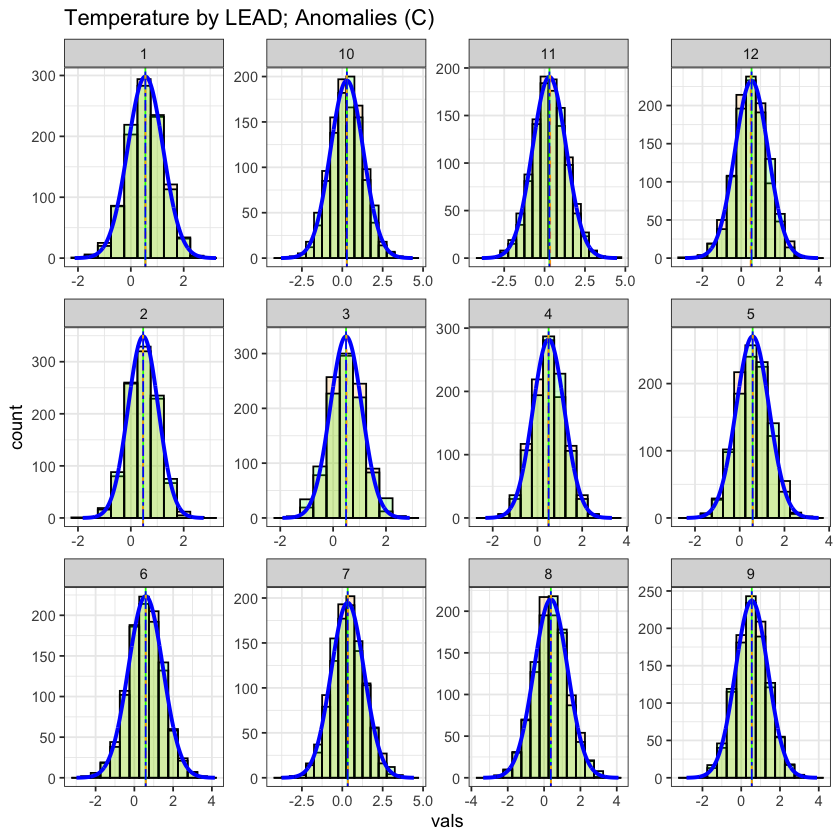

In [13]:
print('Density plots of predicted LEAD Anomalies')
# the anomaly date from NWS is the purple line. Random sample distribution of NWS data is orange
# the mean of the our generated anomlies is the dashed green line. Distribution in green
# analytical distribution in BLUE
# 1000 Future realizations as density plots

#------ Check generated anamalies against NWS anomalies
# --------- 1: NWS random univariate sample (ORANGE)
tempNWSDensity <- TempAnoms[,.(vals = rnorm(1000, mean = Anom_C, sd = ForecastedSD_Temp_C)),
                            .(LEAD)]
tempNWSDensityMean <- tempNWSDensity[,.(UVNWSmean = mean(vals)), .(LEAD)]

# ---------- 2: Generated multivariate anomalies (GREEN)
tempGenAnoms <- data.table(generatedAnomData[, , "dT_C"])
tempGenAnoms$LEAD <- row.names(tempGenAnoms)
#tempGenAnoms$LEAD <- factor(tempGenAnoms$LEAD, levels = c(1:12))
tempGenAnoms <- melt(tempGenAnoms, id.vars = 'LEAD')
tempGenAnomsMean <- tempGenAnoms[,.(MVGenmean = mean(value)),.(LEAD)]

# ----------- 3: Analytical sample (BLUE)
nobs = 1000
tempAnalyticalDensity <- data.frame()

for(L in 1:12){
    z <- subset(TempAnoms, LEAD == L)
    
    meanL <- z$Anom_C
    sdL <- z$ForecastedSD_Temp_C
  
    x <-  seq(meanL - (sdL * 4), 
              meanL + (sdL * 4), length = nobs)
    
    y <-  dnorm(x, mean = z$Anom_C, sd = z$ForecastedSD_Temp_C) 
    
    data <- data.frame(x = x, y = y, 
                       LEAD = L, mean = meanL, sd =sdL )
    
    tempAnalyticalDensity <- rbind(tempAnalyticalDensity, data)
  }

tempAnalyticalDensityMean <-setDT(tempAnalyticalDensity)[,.(AnalyticalMean = mean(x)),.(LEAD)]


# data.table
AllTempMeans <- cbind(tempNWSDensityMean, tempGenAnomsMean, tempAnalyticalDensityMean, NWS_Anom = TempAnoms$Anom_C)
AllTempMeans

# plot

bw <- .5
tempAnalyticalDensity$y_scale <- tempAnalyticalDensity$y * bw * nobs

ggplot() +
  
  geom_histogram(data = tempNWSDensity, aes(x = vals), color = 'black', alpha=.2, fill="orange", binwidth = bw) +
  geom_histogram(data = tempGenAnoms, aes(x = value),color = 'black', alpha=.2, fill="green", binwidth = bw) +
  geom_line(data = tempAnalyticalDensity, aes(x = x, y = y_scale), color = 'blue',  size = 1.1) +
  
  facet_wrap(~LEAD, scales = 'free') +
  labs(title = 'Temperature by LEAD; Anomalies (C)') +
  
  geom_vline(data = tempGenAnomsMean, aes(xintercept = MVGenmean), color = 'green')+
  geom_vline(data = tempNWSDensityMean, aes(xintercept = UVNWSmean), color = 'orange', lty = 'dashed') +
  geom_vline(data = TempAnoms, aes(xintercept = Anom_C), color = 'blue', lty = 'twodash') +
  theme_bw()


## Precipitation 

### Leads - Generated lead anomaly data vs. NWS lead forecasts

[1] "Table of NWS randomly sampled univariate values"


LEAD UVNWS_vals PO   ClimatatologicalMEAN_PPT_cm
1     1    2.095709   0.49 11.9888                    
2     1    1.369162   0.49 11.9888                    
3     1    1.926172   0.49 11.9888                    
4     1    2.325101   0.49 11.9888                    
5     1    1.938821   0.49 11.9888                    
6     1    2.131230   0.49 11.9888                    
7     1    2.484127   0.49 11.9888                    
8     1    2.252003   0.49 11.9888                    
9     1    2.181994   0.49 11.9888                    
10    1    2.171702   0.49 11.9888                    
11    1    1.741173   0.49 11.9888                    
12    1    2.470452   0.49 11.9888                    
13    1    1.864181   0.49 11.9888                    
14    1    1.623035   0.49 11.9888                    
15    1    2.060068   0.49 11.9888                    
16    1    1.588139   0.49 11.9888                    
17    1    1.899547   0.49 11.9888                    
18    1    1.984911   0.49 11.9888                    
19    1    1.834975   0.49 11.9888                    
20    1    2.279122   0.49 11.9888                    
21    1    2.315162   0.49 11.9888                    
22    1    2.130428   0.49 11.9888                    
23    1    1.814395   0.49 11.9888                    
24    1    2.272247   0.49 11.9888                    
25    1    2.170849   0.49 11.9888                    
26    1    2.248490   0.49 11.9888                    
27    1    2.409055   0.49 11.9888                    
28    1    2.587704   0.49 11.9888                    
29    1    2.042214   0.49 11.9888                    
30    1    2.459930   0.49 11.9888                    
⋮     ⋮    ⋮          ⋮    ⋮                          
11971 12   1.945037   0.54 7.0104                     
11972 12   1.992492   0.54 7.0104                     
11973 12   2.523562   0.54 7.0104                     
11974 12   1.784898   0.54 7.0104                     
11975 12   2.061431   0.54 7.0104                     
11976 12   1.814691   0.54 7.0104                     
11977 12   1.395145   0.54 7.0104                     
11978 12   2.447954   0.54 7.0104                     
11979 12   1.431584   0.54 7.0104                     
11980 12   1.624701   0.54 7.0104                     
11981 12   1.990380   0.54 7.0104                     
11982 12   1.601528   0.54 7.0104                     
11983 12   1.963462   0.54 7.0104                     
11984 12   1.945057   0.54 7.0104                     
11985 12   1.674845   0.54 7.0104                     
11986 12   1.335846   0.54 7.0104                     
11987 12   1.485374   0.54 7.0104                     
11988 12   1.874221   0.54 7.0104                     
11989 12   1.811725   0.54 7.0104                     
11990 12   1.759478   0.54 7.0104                     
11991 12   2.642552   0.54 7.0104                     
11992 12   1.738509   0.54 7.0104                     
11993 12   2.002511   0.54 7.0104                     
11994 12   1.662491   0.54 7.0104                     
11995 12   2.201358   0.54 7.0104                     
11996 12   1.186432   0.54 7.0104                     
11997 12   1.447809   0.54 7.0104                     
11998 12   1.248141   0.54 7.0104                     
11999 12   1.975367   0.54 7.0104                     
12000 12   2.116562   0.54 7.0104                     
      ClimatatologicalMEDIAN_PPT_cm UVNWS_ForecastedVal_in
1     15.96895                      4.526654              
2     15.96895                      1.898800              
3     15.96895                      3.810749              
4     15.96895                      5.595520              
5     15.96895                      3.861993              
6     15.96895                      4.684617              
7     15.96895                      6.404379              
8     15.96895                      5.242382              
9     15.96895                      4.915163              
10    

[1] "Analytical Distribution"


x         x_in      x_cm     x_CF      y            y_in        
1     0.9391024 0.8796546 2.234323 0.1399167 0.0004461008 1.452473e-07
2     0.9415048 0.8842532 2.246003 0.1406482 0.0004606068 1.550494e-07
3     0.9439072 0.8888640 2.257715 0.1413815 0.0004755541 1.654914e-07
4     0.9463096 0.8934871 2.269457 0.1421169 0.0004909549 1.766134e-07
5     0.9487120 0.8981224 2.281231 0.1428542 0.0005068220 1.884583e-07
6     0.9511144 0.9027699 2.293036 0.1435934 0.0005231684 2.010713e-07
7     0.9535168 0.9074297 2.304871 0.1443346 0.0005400073 2.145003e-07
8     0.9559192 0.9121017 2.316738 0.1450777 0.0005573525 2.287962e-07
9     0.9583216 0.9167860 2.328636 0.1458228 0.0005752179 2.440131e-07
10    0.9607240 0.9214824 2.340565 0.1465698 0.0005936179 2.602079e-07
11    0.9631264 0.9261912 2.352526 0.1473188 0.0006125673 2.774412e-07
12    0.9655288 0.9309121 2.364517 0.1480697 0.0006320809 2.957772e-07
13    0.9679313 0.9356453 2.376539 0.1488225 0.0006521744 3.152837e-07
14    0.9703337 0.9403908 2.388593 0.1495773 0.0006728635 3.360327e-07
15    0.9727361 0.9451485 2.400677 0.1503341 0.0006941643 3.581003e-07
16    0.9751385 0.9499184 2.412793 0.1510928 0.0007160936 3.815672e-07
17    0.9775409 0.9547006 2.424939 0.1518534 0.0007386683 4.065187e-07
18    0.9799433 0.9594950 2.437117 0.1526160 0.0007619057 4.330451e-07
19    0.9823457 0.9643017 2.449326 0.1533806 0.0007858238 4.612421e-07
20    0.9847481 0.9691206 2.461566 0.1541471 0.0008104408 4.912109e-07
21    0.9871505 0.9739518 2.473838 0.1549155 0.0008357753 5.230583e-07
22    0.9895529 0.9787952 2.486140 0.1556859 0.0008618465 5.568977e-07
23    0.9919553 0.9836509 2.498473 0.1564582 0.0008886740 5.928487e-07
24    0.9943577 0.9885189 2.510838 0.1572325 0.0009162779 6.310380e-07
25    0.9967601 0.9933991 2.523234 0.1580088 0.0009446785 6.715994e-07
26    0.9991625 0.9982915 2.535660 0.1587869 0.0009738970 7.146744e-07
27    1.0015649 1.0031962 2.548118 0.1595671 0.0010039549 7.604127e-07
28    1.0039673 1.0081132 2.560608 0.1603492 0.0010348740 8.089723e-07
29    1.0063697 1.0130425 2.573128 0.1611332 0.0010666770 8.605202e-07
30    1.0087721 1.0179840 2.585679 0.1619192 0.0010993868 9.152330e-07
⋮     ⋮         ⋮         ⋮        ⋮         ⋮            ⋮           
11971 3.086575  8.061921  20.47728 2.211189  0.0009161557 2.366013e-06
11972 3.089458  8.075871  20.51271 2.215015  0.0008888975 2.237306e-06
11973 3.092341  8.089832  20.54817 2.218844  0.0008623950 2.115348e-06
11974 3.095224  8.103804  20.58366 2.222676  0.0008366290 1.999802e-06
11975 3.098106  8.117787  20.61918 2.226511  0.0008115809 1.890342e-06
11976 3.100989  8.131781  20.65472 2.230349  0.0007872321 1.786661e-06
11977 3.103872  8.145786  20.69030 2.234191  0.0007635649 1.688467e-06
11978 3.106755  8.159803  20.72590 2.238035  0.0007405617 1.595479e-06
11979 3.109638  8.173830  20.76153 2.241882  0.0007182055 1.507434e-06
11980 3.112521  8.187869  20.79719 2.245733  0.0006964794 1.424078e-06
11981 3.115404  8.201918  20.83287 2.249586  0.0006753673 1.345172e-06
11982 3.118287  8.215979  20.86859 2.253443  0.0006548532 1.270487e-06
11983 3.121169  8.230050  20.90433 2.257302  0.0006349215 1.199806e-06
11984 3.124052  8.244133  20.94010 2.261165  0.0006155569 1.132923e-06
11985 3.126935  8.258227  20.97590 2.265031  0.0005967447 1.069641e-06
11986 3.129818  8.272332  21.01172 2.268899  0.0005784703 1.009774e-06
11987 3.132701  8.286448  21.04758 2.272771  0.0005607195 9.531444e-07
11988 3.135584  8.300575  21.08346 2.276646  0.0005434787 8.995838e-07
11989 3.138467  8.314713  21.11937 2.280523  0.0005267341 8.489322e-07
11990 3.141350  8.328863  21.15531 2.284404  0.0005104727 8.010375e-07
11991 3.144233  8.343023  21.19128 2.288288  0.0004946816 7.557551e-07
11992 3.147115  8.357194  21.22727 2.292175  0.0004793483 7.129478e-07
11993 3.149998  8.371377  21.26330 2.296065  0.0004644604 6.724853e-07
11994 3.152881  8.385570  21.29935 2.299958  0.0004500061 6.342439e-07
11995 3.155764  8.399775  21.3

[1] "Multivariate sampled precipitation values - total forecast amount in transformed units"
[1] "Table of Means - Total Forecasted PPT (Transformed Units)"


LEAD UVNWSmean LEAD MVGenMean LEAD AnalyticalMean_PO NWS_Forecast_Mean_PO
1   1   2.128730  1    2.139102   1   2.139102          2.139102            
2   2   2.940497  2    2.949649   2   2.949649          2.949649            
3   3   3.053450  3    3.084229   3   3.076210          3.076210            
4   4   1.698850  4    1.702251   4   1.691286          1.691286            
5   5   1.440073  5    1.493066   5   1.446785          1.446785            
6   6   1.373085  6    1.380380   6   1.380380          1.380380            
7   7   1.398524  7    1.443448   7   1.401673          1.401673            
8   8   1.457881  8    1.479023   8   1.459636          1.459636            
9   9   1.839512  9    1.835570   9   1.832718          1.832718            
10 10   1.553627  10   1.579158  10   1.564300          1.564300            
11 11   1.100620  11   1.109296  11   1.109296          1.109296            
12 12   1.731856  12   1.730178  12   1.730178          1.730178            
   PO  
1  0.49
2  0.61
3  0.68
4  0.40
5  0.28
6  0.27
7  0.25
8  0.28
9  0.51
10 0.48
11 0.29
12 0.54

[1] "Table of Medians - Forecasted PPT (Transformed Units)"


LEAD UVNWSmedian LEAD MVGenMed LEAD AnalyticalMedian_PO NWS_Forecast_Mean_PO
1   1   2.134504    1    2.138451  1   2.139102            2.139102            
2   2   2.938432    2    2.951688  2   2.949649            2.949649            
3   3   3.061133    3    3.082234  3   3.076210            3.076210            
4   4   1.696237    4    1.698286  4   1.691286            1.691286            
5   5   1.438445    5    1.485063  5   1.446785            1.446785            
6   6   1.361123    6    1.378795  6   1.380380            1.380380            
7   7   1.399684    7    1.433855  7   1.401673            1.401673            
8   8   1.451933    8    1.480646  8   1.459636            1.459636            
9   9   1.836535    9    1.836333  9   1.832718            1.832718            
10 10   1.552076    10   1.582719 10   1.564300            1.564300            
11 11   1.100616    11   1.113427 11   1.109296            1.109296            
12 12   1.737163    12   1.714421 12   1.730178            1.730178            
   PO  
1  0.49
2  0.61
3  0.68
4  0.40
5  0.28
6  0.27
7  0.25
8  0.28
9  0.51
10 0.48
11 0.29
12 0.54

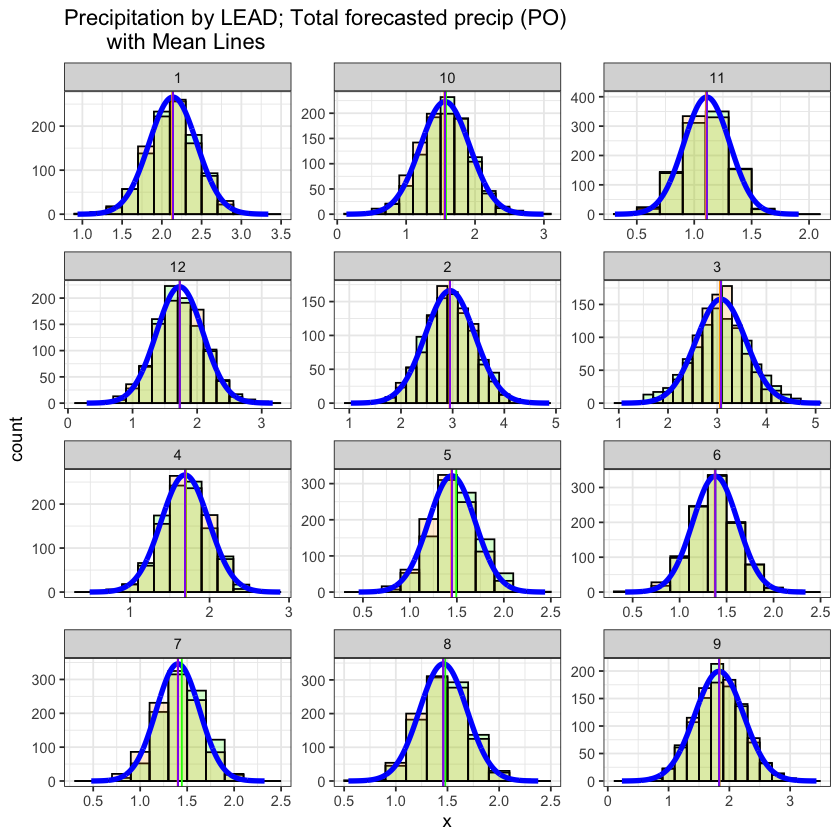

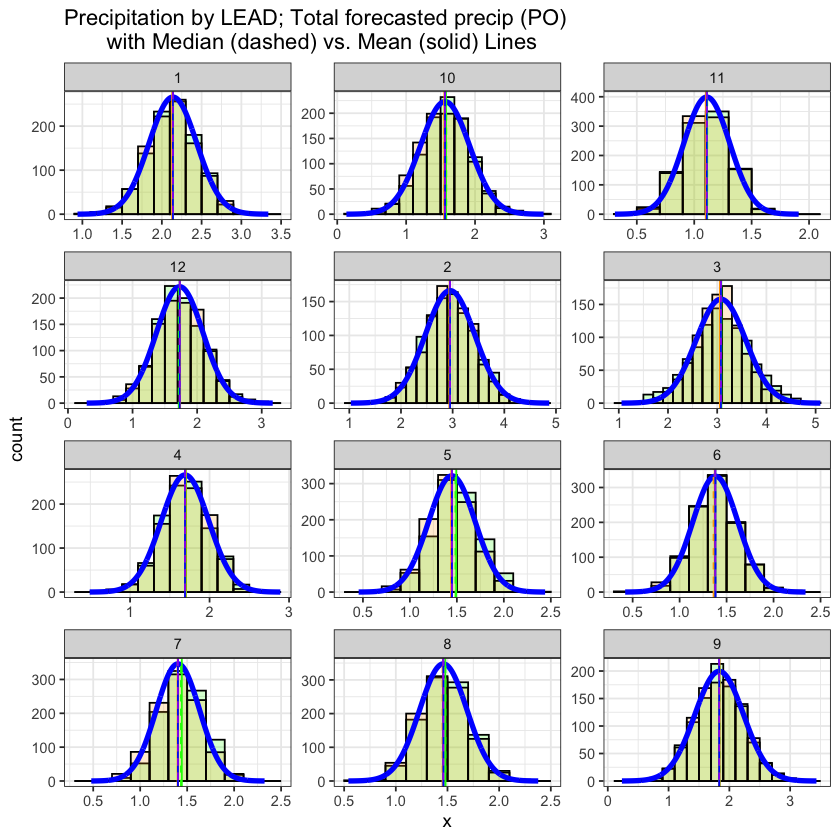

In [19]:
 # --------- 1: NWS random univariate sample (orange)
s <- 1000
pptNWSDensity <- PPTAnoms[,.(UVNWS_vals = rnorm(s, mean = ForecastedMEAN_PPT_PO, sd = ForecastedSD)), .(LEAD)]
pptNWSDensityMean <- pptNWSDensity[,.(UVNWSmean = mean(UVNWS_vals)), .(LEAD)]
pptNWSDensityMedian <- pptNWSDensity[,.(UVNWSmedian = median(UVNWS_vals)), .(LEAD)]

# conversions!
pptNWSDensity <- merge(pptNWSDensity, PPTAnoms[,c('LEAD', 'PO', 'ClimatatologicalMEAN_PPT_cm', 'ClimatatologicalMEDIAN_PPT_cm')])
pptNWSDensity$UVNWS_ForecastedVal_in <- (pptNWSDensity$UVNWS_vals) ^ (1/pptNWSDensity$PO)
pptNWSDensity$UVNWS_ForecastedVal_cm <- pptNWSDensity$UVNWS_ForecastedVal_in * 2.54
pptNWSDensity$UVNWS_PPT_CF_MEAN <- pptNWSDensity$UVNWS_ForecastedVal_cm / pptNWSDensity$ClimatatologicalMEAN_PPT_cm
pptNWSDensity$UVNWS_PPT_CF_MEDIAN <- pptNWSDensity$UVNWS_ForecastedVal_cm / pptNWSDensity$ClimatatologicalMEDIAN_PPT_cm

print('Table of NWS randomly sampled univariate values')
pptNWSDensity

# ---------- 3: Analytical distribution (BLUE)
pptAnalyticalDensity <- data.frame()

for(L in 1:12) {
  z <- subset(PPTAnoms, LEAD == L)
  zz <- subset(pptNWSDensity, LEAD == L)
  
  # sequence of values within 4 sds of the mean
  climmean <- z$ClimatatologicalMEAN_PPT_cm
  climmedian <- z$ClimatatologicalMEDIAN_PPT_cm
  meanL <- z$ForecastedMEAN_PPT_PO
  sdL <- z$ForecastedSD
  PO <- z$PO
  
  x <-  seq(meanL - (sdL * 4), 
            meanL + (sdL * 4), length = s)
  
  x_in <-  x ^ (1/PO)
  x_cm <- x_in * 2.54
  x_CF <- x_cm/climmedian
  
  # predictions of curve
  y <-  dnorm(x, mean = meanL, sd = sdL)
  # convert
  y_in <- y ^ (1/PO)
  y_cm <- y_in * 2.54
  y_CF <- y_cm/climmedian
  
  data <- data.frame(x = x, x_in = x_in, x_cm = x_cm, x_CF = x_CF,
                     y = y,  y_in = y_in, y_cm = y_cm, y_CF = y_CF,
                     LEAD = L, mean = meanL, sd =sdL, PO = PO )
  
  pptAnalyticalDensity <- rbind(pptAnalyticalDensity, data)
  
}
print('Analytical Distribution')
pptAnalyticalDensity
pptAnalyticalDensityMean <- setDT(pptAnalyticalDensity)[,.(AnalyticalMean_PO = mean(x)),.(LEAD)]
pptAnalyticalDensityMedian <- setDT(pptAnalyticalDensity)[,.(AnalyticalMedian_PO = median(x)),.(LEAD)]


# ---------- 2: Generated multivariate anomalies (Green)
# transformed forecast
pptGenAnoms <- data.table(generatedAnomData[, , "PT_GenForecasted_PO"])
pptGenAnoms$LEAD <- row.names(pptGenAnoms)
pptGenAnoms$LEAD <- factor(pptGenAnoms$LEAD, levels = c(1:12))
print('Multivariate sampled precipitation values - total forecast amount in transformed units')
#pptGenAnoms

pptGenAnoms <- melt(pptGenAnoms, id.vars = 'LEAD')
pptGenAnomsMean <- pptGenAnoms[,.(MVGenMean = mean(value)),.(LEAD)]
pptGenAnomsMedian <- pptGenAnoms[,.(MVGenMed = median(value)),.(LEAD)]


# Make Table of means 
AllPPTMeans_PO <- cbind(pptNWSDensityMean, pptGenAnomsMean, pptAnalyticalDensityMean, NWS_Forecast_Mean_PO = PPTAnoms$ForecastedMEAN_PPT_PO, PO = PPTAnoms$PO)
AllPPTMedians_PO <- cbind(pptNWSDensityMedian, pptGenAnomsMedian, pptAnalyticalDensityMedian, NWS_Forecast_Mean_PO = PPTAnoms$ForecastedMEAN_PPT_PO, PO = PPTAnoms$PO)

# scale!
bw1 <- .2 # binwidth .. important for scaling y axis to a count
pptAnalyticalDensity$y_scale <- pptAnalyticalDensity$y * bw1 * s
pptAnalyticalDensityMean <- setDT(pptAnalyticalDensity)[,.(AnalyticalMean_PO = mean(x)),.(LEAD)]
pptAnalyticalDensityMedian <- setDT(pptAnalyticalDensity)[,.(AnalyticalMedian_PO = median(x)),.(LEAD)]

p1 <- ggplot(pptAnalyticalDensity, aes(x = x)) + 
  geom_histogram(data = pptGenAnoms, aes(x = value),  color = 'black', fill = 'green', alpha = .2,  binwidth = bw1) +
  geom_histogram(data = pptNWSDensity, aes(x = UVNWS_vals), color = 'black', fill = 'orange', alpha = .2, binwidth = bw1) +
  geom_line(aes(y = y_scale), color = 'blue', size = 1.5) + 
  
  facet_wrap(~ LEAD, scales = 'free', nrow =4) +
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (PO)') +
  theme_bw()


p1Means <- p1 +
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (PO) 
       with Mean Lines') +
  
  geom_vline(data = pptGenAnomsMean, aes(xintercept = MVGenMean), color = 'green')+
  geom_vline(data = pptNWSDensityMean, aes(xintercept = UVNWSmean), color = 'orange') +
  geom_vline(data = pptAnalyticalDensityMean, aes(xintercept = AnalyticalMean_PO), color = 'blue') +
  geom_vline(data = PPTAnoms[1:12,], aes(xintercept = ForecastedMEAN_PPT_PO), color = 'purple') 

p1Medians <- p1 +
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (PO)
       with Median (dashed) vs. Mean (solid) Lines') +
  # these are means
   geom_vline(data = pptGenAnomsMean, aes(xintercept = MVGenMean), color = 'green')+
  geom_vline(data = pptNWSDensityMean, aes(xintercept = UVNWSmean), color = 'orange') +
  geom_vline(data = pptAnalyticalDensityMean, aes(xintercept = AnalyticalMean_PO), color = 'blue') +
  geom_vline(data = PPTAnoms[1:12,], aes(xintercept = ForecastedMEAN_PPT_PO), color = 'purple') +
  # these are medians
 geom_vline(data = pptGenAnomsMedian, aes(xintercept = MVGenMed), color = 'green', lty = 'dashed')+
  geom_vline(data = pptNWSDensityMedian, aes(xintercept = UVNWSmedian), color = 'orange', lty = 'dashed') +
  geom_vline(data = pptAnalyticalDensityMedian, aes(xintercept = AnalyticalMedian_PO), color = 'blue', lty = 'dashed')

print('Table of Means - Total Forecasted PPT (Transformed Units)')
#PPTAnoms
AllPPTMeans_PO
p1Means
print('Table of Medians - Forecasted PPT (Transformed Units)')
AllPPTMedians_PO
p1Medians


[1] "Multivariate sampled precipitation values - total forecast amount in cm"
[1] "Table of Means - Total Forecasted PPT (cm)"


LEAD UVNWSmean LEAD MVGenMean LEAD AnalyticalMean_cm NWS_Forecast_Mean_cm
1   1   12.141978 1    12.238936  1   13.326287         11.9888             
2   2   15.085360 2    15.168316  2   16.082757         14.9606             
3   3   13.231975 3    13.489907  3   13.932621         13.2588             
4   4   10.086010 4    10.160239  4   12.404025          9.4488             
5   5   10.625777 5    11.986315  5   16.500711          9.4996             
6   6    9.549400 6     9.664045  6   15.359499          8.3820             
7   7   11.476673 7    12.729542  7   18.682340          9.8044             
8   8   10.888266 8    11.421807  8   15.863981          9.8044             
9   9    8.763308 9     8.733310  9   10.332466          8.3312             
10 10    6.755591 10    6.959972 10    8.479576          6.4516             
11 11    4.037254 11    4.133347 11    6.341159          3.6322             
12 12    7.293427 12    7.249782 12    8.298348          7.0104

[1] "Table of Medians - Total Forecasted PPT (cm)"


LEAD UVNWSmedian LEAD MVGenMed  LEAD AnalyticalMedian_cm
1   1   11.936267   1    11.981352  1   11.988804          
2   2   14.867450   2    14.977563  2   14.960603          
3   3   13.163350   3    13.296999  3   13.258802          
4   4    9.518097   4     9.546873  4    9.448809          
5   5    9.305509   5    10.428197  5    9.499621          
6   6    7.957002   6     8.346410  6    8.382020          
7   7    9.748852   7    10.736291  7    9.804426          
8   8    9.620872   8    10.317818  8    9.804418          
9   9    8.365263   9     8.363448  9    8.331206          
10 10    6.347006   10    6.610874 10    6.451606          
11 11    3.535135   11    3.679055 11    3.632208          
12 12    7.062895   12    6.892626 12    7.010404          
   NWS_Forecast_Mean_cm
1  11.9888             
2  14.9606             
3  13.2588             
4   9.4488             
5   9.4996             
6   8.3820             
7   9.8044             
8   9.8044             
9   8.3312             
10  6.4516             
11  3.6322             
12  7.0104

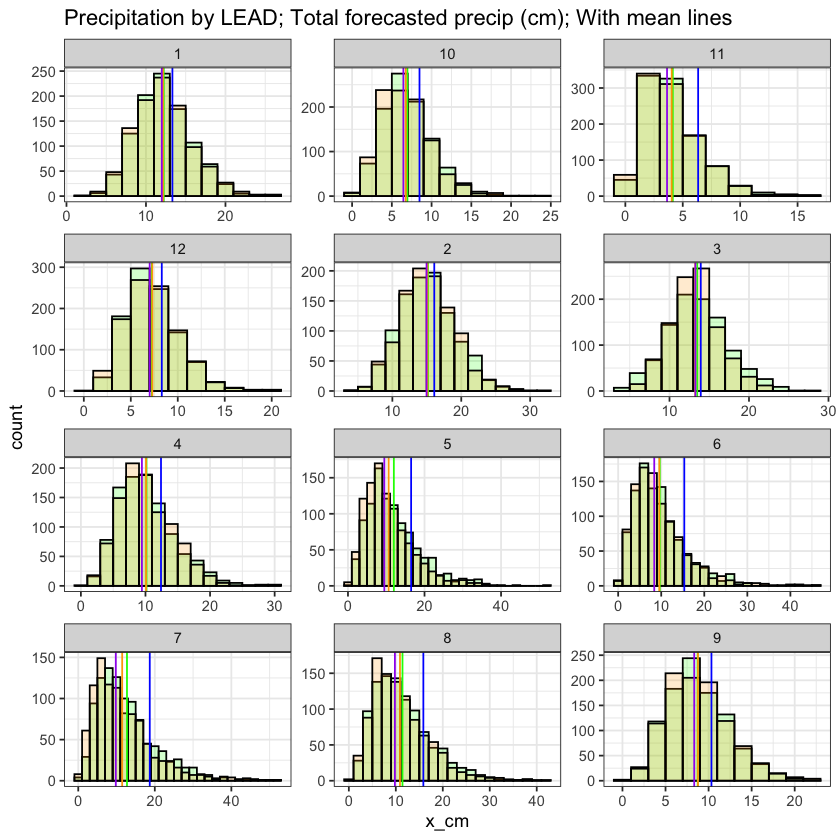

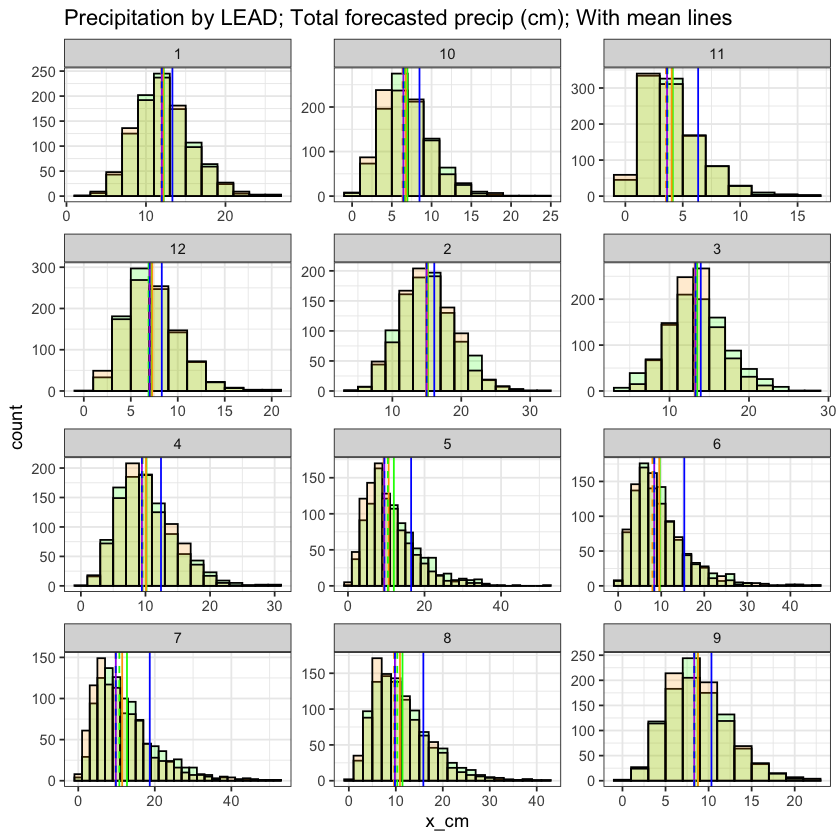

In [21]:
# ----------------- in centimeters ------------------------------------
# 1 UV NWS (orange)
pptNWSDensityMean <- pptNWSDensity[,.(UVNWSmean = mean(UVNWS_ForecastedVal_cm)), .(LEAD)]
pptNWSDensityMedian <- pptNWSDensity[,.(UVNWSmedian = median(UVNWS_ForecastedVal_cm)), .(LEAD)]

# 2 MV Gen (Green)
pptGenAnoms <- data.table(generatedAnomData[, , "PPT_GenForecasted_cm"]) # to see how these numbers  are converted to cm .... need to visit generateAnomaly
pptGenAnoms$LEAD <- row.names(pptGenAnoms)
print('Multivariate sampled precipitation values - total forecast amount in cm')
#pptGenAnoms

pptGenAnoms <- melt(pptGenAnoms, id.vars = 'LEAD')
pptGenAnomsMean <- pptGenAnoms[,.(MVGenMean = mean(value)),.(LEAD)]
pptGenAnomsMedian <- pptGenAnoms[,.(MVGenMed = median(value)),.(LEAD)]

# 3 Analytical (BLUE)
pptAnalyticalDensityMean <- setDT(pptAnalyticalDensity)[,.(AnalyticalMean_cm = mean(x_cm)),.(LEAD)]
pptAnalyticalDensityMedian <- setDT(pptAnalyticalDensity)[,.(AnalyticalMedian_cm = median(x_cm)),.(LEAD)]

# Make Table of means/median
AllPPTMeans_CM <- cbind(pptNWSDensityMean, pptGenAnomsMean, pptAnalyticalDensityMean, NWS_Forecast_Mean_cm = PPTAnoms$ForecastedMEAN_PPT_cm)
AllPPTMedians_CM <- cbind(pptNWSDensityMedian, pptGenAnomsMedian, pptAnalyticalDensityMedian, NWS_Forecast_Mean_cm = PPTAnoms$ForecastedMEAN_PPT_cm)

# plot

# scale!
bw2 <- 2 # binwidth .. important for scaling y axis to a count
pptAnalyticalDensity$y_cm_scale <- pptAnalyticalDensity$y_cm * 500

p2 <- ggplot(pptAnalyticalDensity, aes(x = x_cm)) + 
  geom_histogram(data = pptGenAnoms, aes(x = value),  color = 'black', fill = 'green', alpha = .2,  binwidth = bw2) +
  geom_histogram(data = pptNWSDensity, aes(x = UVNWS_ForecastedVal_cm), color = 'black', fill = 'orange', alpha = .2, binwidth = bw2) +
  #geom_line(aes(y = y_cm_scale), color = 'blue', size = 1.5) + 
  
  facet_wrap(~ LEAD, scales = 'free', nrow =4) +
  
  theme_bw()


p2Means <- p2 +  
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (cm); With mean lines') +
  
  #means
  geom_vline(data = pptGenAnomsMean, aes(xintercept = MVGenMean), color = 'green')+
  geom_vline(data = pptNWSDensityMean, aes(xintercept = UVNWSmean), color = 'orange') +
  geom_vline(data = pptAnalyticalDensityMean, aes(xintercept = AnalyticalMean_cm), color = 'blue') +
  geom_vline(data = PPTAnoms[1:12,], aes(xintercept = ForecastedMEAN_PPT_cm), color = 'purple')

 
p2Medians <- p2 +  
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (cm); With mean lines') +
  
  #means
  geom_vline(data = pptGenAnomsMean, aes(xintercept = MVGenMean), color = 'green')+
  geom_vline(data = pptNWSDensityMean, aes(xintercept = UVNWSmean), color = 'orange') +
  geom_vline(data = pptAnalyticalDensityMean, aes(xintercept = AnalyticalMean_cm), color = 'blue') +
  geom_vline(data = PPTAnoms[1:12,], aes(xintercept = ForecastedMEAN_PPT_cm), color = 'purple') +
  # these are medians
  geom_vline(data = pptGenAnomsMedian, aes(xintercept = MVGenMed), color = 'green', lty = 'dashed')+
  geom_vline(data = pptNWSDensityMedian, aes(xintercept = UVNWSmedian), color = 'orange', lty = 'dashed') +
  geom_vline(data = pptAnalyticalDensityMedian, aes(xintercept = AnalyticalMedian_cm), color = 'blue', lty = 'dashed')



print('Table of Means - Total Forecasted PPT (cm)')
AllPPTMeans_CM
p2Means
print('Table of Medians - Total Forecasted PPT (cm)')
AllPPTMedians_CM
p2Medians



[1] "Table of Means - Correction Factor"


LEAD UVNWSmean LEAD MVGenMean LEAD AnalyticalMean_CF NWS_PPT_CF_BasedOnMean
1   1   0.7603493 1    0.8184625  1   0.8345125         1.000000              
2   2   0.4679005 2    0.4518262  2   0.4988367         1.000000              
3   3   0.4046341 3    0.3772386  3   0.4260598         1.003846              
4   4   1.1937107 4    1.1945138  4   1.4680549         1.016393              
5   5   1.8966949 5    2.1216778  5   2.9453670         1.123123              
6   6   1.7349676 6    1.7746724  6   2.7905662         1.000000              
7   7   2.2536302 7    2.4715847  7   3.6685795         1.128655              
8   8   1.7919173 8    1.9974567  8   2.6107869         1.048913              
9   9   0.8638313 9    0.8489617  9   1.0185090         1.003058              
10 10   0.9721418 10   1.0158520 10   1.2202264         1.020080              
11 11   1.2651098 11   1.2829529 11   1.9870594         1.000000              
12 12   0.7875627 12   0.7989935 12   0.8960766         1.000000              
   NWS_PPT_CF_BasedOnMedian
1  0.7507570               
2  0.4640309               
3  0.4054544               
4  1.1182948               
5  1.6956730               
6  1.5228704               
7  1.9252525               
8  1.6135419               
9  0.8212368               
10 0.9283969               
11 1.1381826               
12 0.7570008

Warning message:
“Removed 1297 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 1087 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”
Warning message:
“Removed 4 rows containing missing values (geom_vline).”


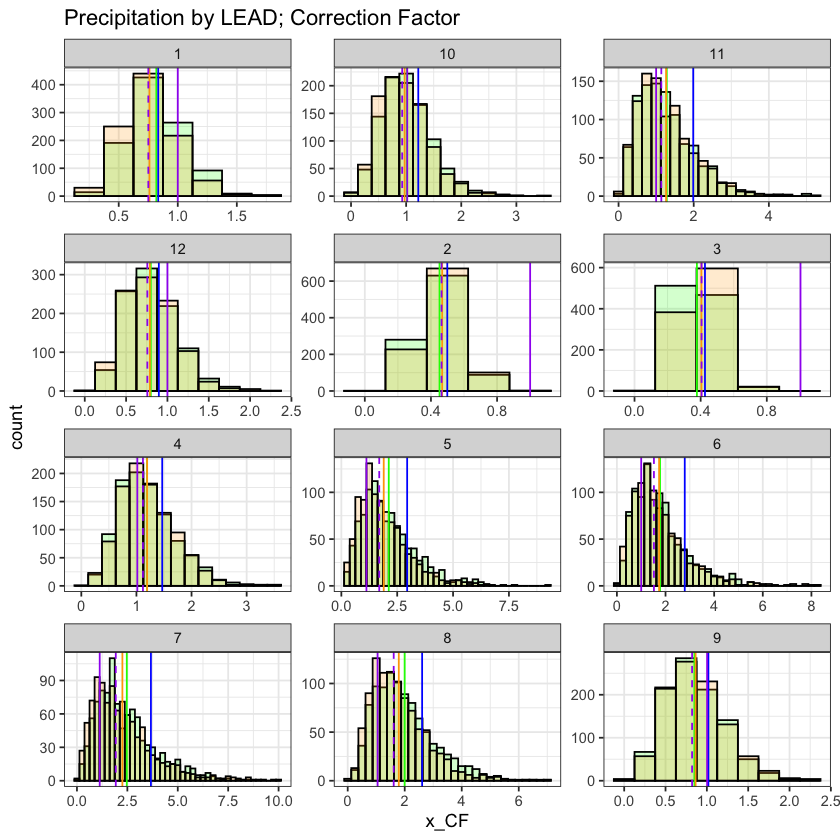

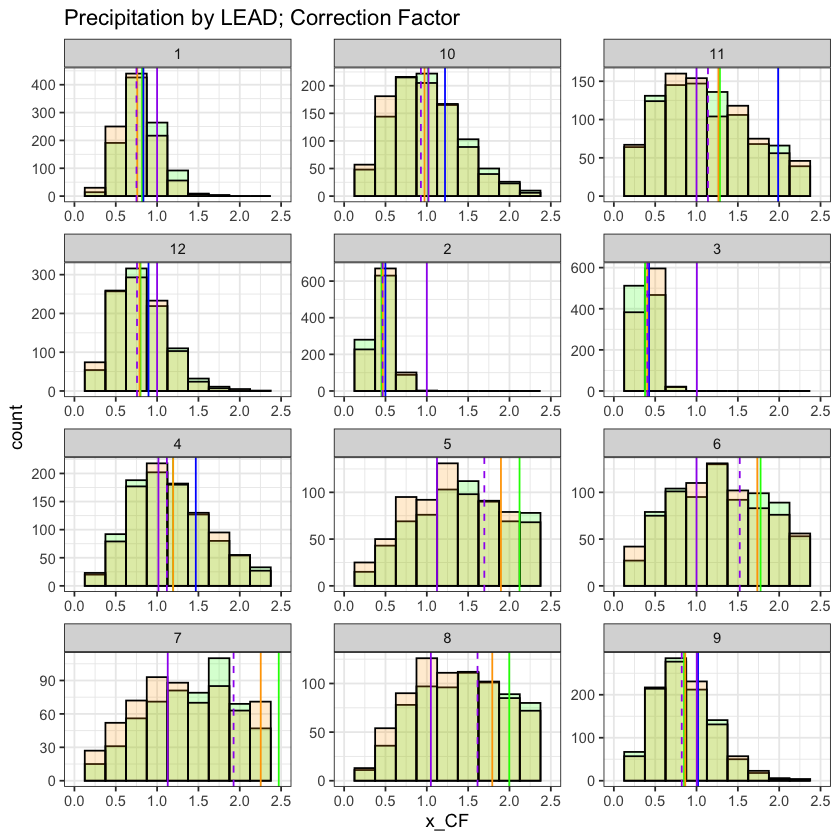

In [23]:
# CF values calculated as forecasted mean / CLIMATOLOGICAL MEDIAN
# 1 (Orange)
pptNWSDensityMean <- pptNWSDensity[,.(UVNWSmean = mean(UVNWS_PPT_CF_MEDIAN)), .(LEAD)]
pptNWSDensityMedian <- pptNWSDensity[,.(UVNWSmedian = median(UVNWS_PPT_CF_MEDIAN)), .(LEAD)]

# 2 (Green)
pptGenAnoms <- data.table(generatedAnomData [, , "PPT_CF"])
pptGenAnoms$LEAD <- row.names(pptGenAnoms)
pptGenAnoms <- melt(pptGenAnoms, id.vars = 'LEAD')
pptGenAnomsMean <- pptGenAnoms[,.(MVGenMean = mean(value)),.(LEAD)]
pptGenAnomsMedian <- pptGenAnoms[,.(MVGenMed = median(value)),.(LEAD)]

# 3 Analytical (BLUE)
pptAnalyticalDensityMean <- setDT(pptAnalyticalDensity)[,.(AnalyticalMean_CF = mean(x_CF)),.(LEAD)]
pptAnalyticalDensityMedian <- setDT(pptAnalyticalDensity)[,.(AnalyticalMedian_CF = median(x_CF)),.(LEAD)]

# Make Table of means
AllPPTMeans_CF <- cbind(pptNWSDensityMean, pptGenAnomsMean, pptAnalyticalDensityMean, NWS_PPT_CF_BasedOnMean = PPTAnoms$Anom_CF_MEAN, NWS_PPT_CF_BasedOnMedian = PPTAnoms$Anom_CF_MEDIAN)

# plot

# scale!
bw3 <- .25 # binwidth .. important for scaling y axis to a count
#pptAnalyticalDensity$y_CF_scale <- pptAnalyticalDensity$y_CF * bw3 * nobs

p3 <- ggplot(pptAnalyticalDensity, aes(x = x_CF)) + 
  geom_histogram(data = pptGenAnoms, aes(x = value),  color = 'black', fill = 'green', alpha = .2,  binwidth = bw3) +
  geom_histogram(data = pptNWSDensity, aes(x = UVNWS_PPT_CF_MEDIAN), color = 'black', fill = 'orange', alpha = .2, binwidth = bw3) +
  #geom_line(aes(y = y_CF_scale), color = 'blue', size = 1.5)  +
  
  facet_wrap(~ LEAD, scales = 'free', nrow =4) +
  theme_bw() 

p3Means <- p3 +
  
  labs(title = 'Precipitation by LEAD; Correction Factor') +
  
  geom_vline(data = pptGenAnomsMean, aes(xintercept = MVGenMean), color = 'green') +
  geom_vline(data = pptNWSDensityMean, aes(xintercept = UVNWSmean), color = 'orange')+
  geom_vline(data = pptAnalyticalDensityMean, aes(xintercept = AnalyticalMean_CF), color = 'blue') +
  
  geom_vline(data = PPTAnoms[1:12,], aes(xintercept = Anom_CF_MEAN), color = 'purple') +
  geom_vline(data = PPTAnoms[1:12,], aes(xintercept = Anom_CF_MEDIAN), color = 'purple', lty = 'dashed') 


p3MeansZoom <- p3Means +    xlim(0, 2.5)
# ---------------------------------
print('Table of Means - Correction Factor')
AllPPTMeans_CF
p3Means
p3MeansZoom

Next, the anomalies generated for each lead must be transformed into monthly values so we can apply the anomalies to the historical data. Using the monthLeads table we loop through each month and find the affiliated leads. Values are then averaged across leads for monthly temperature anomaly and precipiation correction factor.

Finally, these monthly anomalies are then added (temp) or multipled (ppt) to each day in the relative month across the historical series, to generate future daily data for a 30 year period.


In [8]:
# Step 3 Get monthly averages across leads --------------------------------------------------
nn <- 1
OneYearAnom <- generatedAnomData[ , nn, ]
    
yearlydat <- data.frame(matrix(nrow = 12, ncol = 3))
names(yearlydat) <- c('tempAnom', 'pptAnom_cm', 'pptAnom_CF')
yearlydat$Month <- as.numeric(row.names(yearlydat))
  
for(m in c(yearlydat$Month)){ # for each month, m, in a year, nn
    
    mLeads <- c(t(monthLeads[monthLeads$Month == m, 3:5]))

    #temp
    yearlydat[m, 1] <- mean(OneYearAnom[mLeads, 'dT_C'], na.rm = TRUE) 
      
    # ppt cm # don't use this for calculations but downstream for looking at differences in predicted data
    OneYearAnom  <- cbind(OneYearAnom, Anom_cm =  OneYearAnom[,4] - PPTAnoms$ClimatatologicalMEAN_PPT_cm[1:12])
    yearlydat[m, 2] <-  mean(OneYearAnom[mLeads, 'Anom_cm'], na.rm = TRUE)
      
    # ppt correction factor
    yearlydat[m, 3] <-  mean(OneYearAnom[mLeads, 'PPT_CF'], na.rm = TRUE)

}
print(yearlydat)

print('summary of weather data before anomalies')
summary(wdata)
### Find month in wdata and merge anomalies
wdata$Month <-  month(as.Date(strptime(paste(wdata$Year, wdata$DOY), format="%Y %j"), format="%m-%d-%Y"))
wdata <- merge(wdata, yearlydat)

### Temp ------------------------------------------------------------------------------------ 
wdata$Tmax_C <- wdata$Tmax_C + wdata$tempAnom
wdata$Tmin_C <- wdata$Tmin_C + wdata$tempAnom

### Precip ----------------------------------------------------------------------------
wdata$PPT_cm <- wdata$PPT_cm * wdata$pptAnom_CF

# That's it
wdata <- wdata[,c('Year', 'DOY', 'Tmax_C', 'Tmin_C', 'PPT_cm')]
print('summary of weather data after anomalies')
summary(wdata)

     tempAnom pptAnom_cm pptAnom_CF Month
1  0.41457146  3.6064309  1.3905186     1
2  0.67908492  2.5916957  1.2687166     2
3  0.08481527  3.7715564  1.4580463     3
4  0.41157866 -0.3459988  0.8637357     4
5  0.29991653 -0.3131285  0.8533670     5
6  0.42958384 -0.7305686  0.9390624     6
7  0.55577175 -2.7543893  0.8098381     7
8  0.21110998 -0.4464511  0.9784501     8
9  0.19643487 -0.2307328  0.9957718     9
10 0.33589407  0.6749224  1.0210013    10
11 0.56938216 -0.3769739  0.9560905    11
12 0.65337214 -0.2845405  0.9665213    12
[1] "summary of weather data before anomalies"


     Date                Year           DOY            Tmax_C      
 Length:15341       Min.   :1979   Min.   :  1.0   Min.   :-8.912  
 Class :character   1st Qu.:1989   1st Qu.: 92.0   1st Qu.:10.202  
 Mode  :character   Median :2000   Median :183.0   Median :17.783  
                    Mean   :2000   Mean   :183.1   Mean   :17.403  
                    3rd Qu.:2010   3rd Qu.:274.0   3rd Qu.:25.264  
                    Max.   :2020   Max.   :366.0   Max.   :44.891  
     Tmin_C             PPT_cm       
 Min.   :-25.3087   Min.   :0.00000  
 1st Qu.: -4.5787   1st Qu.:0.00000  
 Median :  0.7622   Median :0.00000  
 Mean   :  1.3686   Mean   :0.15378  
 3rd Qu.:  7.9749   3rd Qu.:0.06728  
 Max.   : 32.2334   Max.   :9.29819  

[1] "summary of weather data after anomalies"


      Year           DOY            Tmax_C           Tmin_C       
 Min.   :1979   Min.   :  1.0   Min.   :-8.233   Min.   :-24.655  
 1st Qu.:1989   1st Qu.: 92.0   1st Qu.:10.635   1st Qu.: -4.155  
 Median :2000   Median :183.0   Median :18.139   Median :  1.147  
 Mean   :2000   Mean   :183.1   Mean   :17.804   Mean   :  1.770  
 3rd Qu.:2010   3rd Qu.:274.0   3rd Qu.:25.566   3rd Qu.:  8.294  
 Max.   :2020   Max.   :366.0   Max.   :45.321   Max.   : 32.663  
     PPT_cm        
 Min.   : 0.00000  
 1st Qu.: 0.00000  
 Median : 0.00000  
 Mean   : 0.16593  
 3rd Qu.: 0.06823  
 Max.   :12.92931  

### Monthly - generated monthly anom data vs. NWS data (NWS lead data averaged to correct month)

[1] "Density and box plots of monthly anomalies used in SOILWAT2 vs NWS"


Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


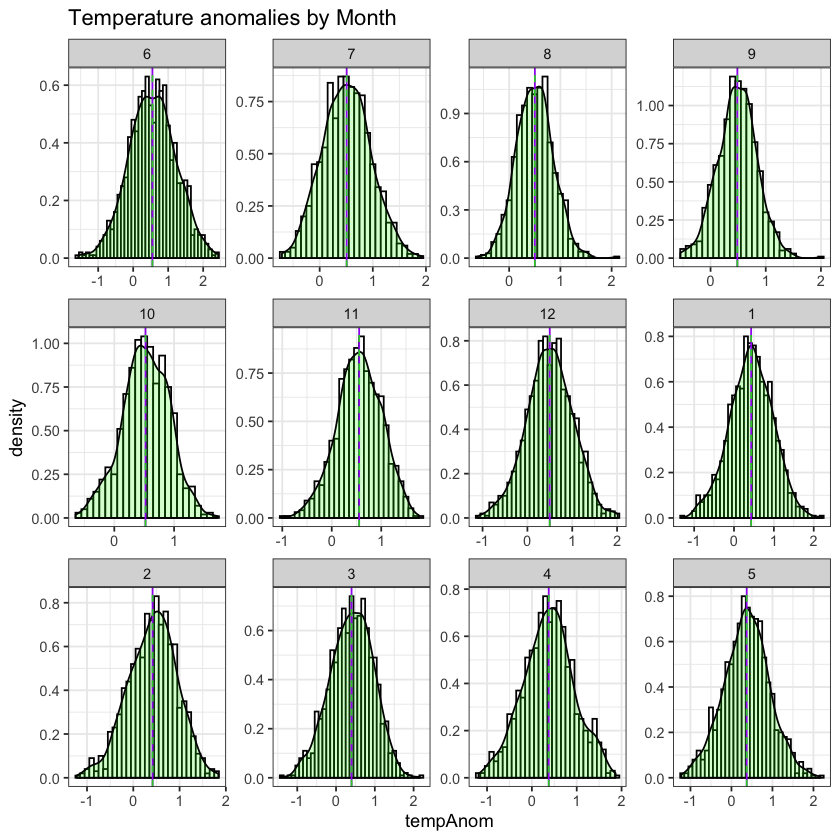

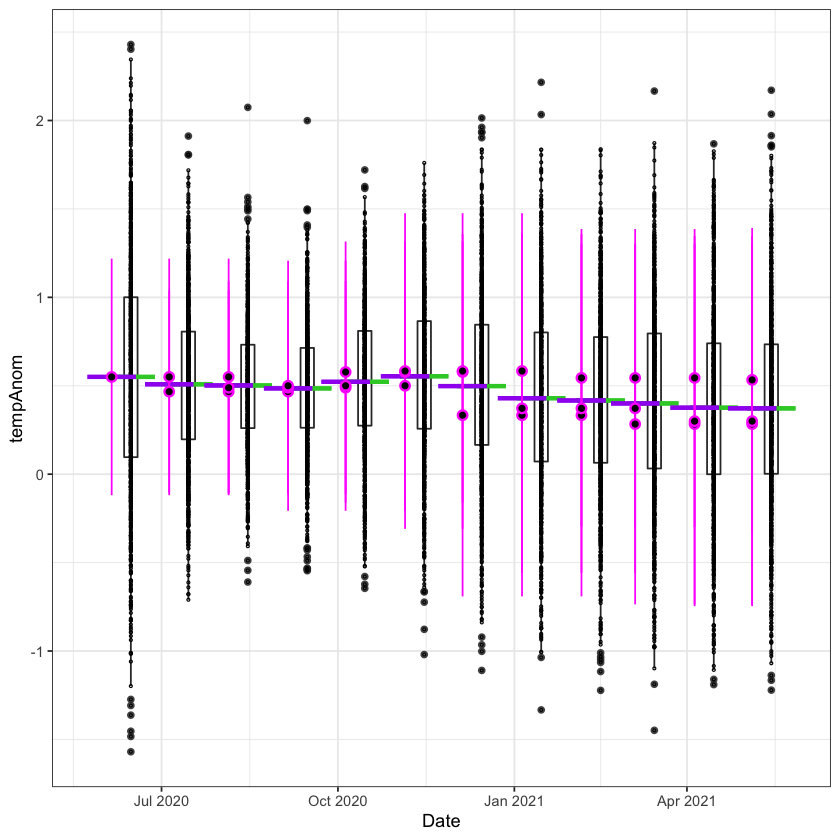

In [34]:
source('figureCode/testFigs/FigureDataPrep.R')
# Plots comparing the distribution of generated anomaly data at the Monthly level
# to NWS values for the same monthly periods

print('Density and box plots of monthly anomalies used in SOILWAT2 vs NWS')
MonthlyAnoms2 <- MonthlyAnoms # monthly anamoly data entered into SW
MonthlyAnoms2$Month <- factor(MonthlyAnoms2$Month, levels = c(6:12, 1:5))
generatedMean <- setDT(MonthlyAnoms2)[,.(meanGenAnom = mean(tempAnom)), .(Month)]

# ----- 100 sets of monthly anomalies vs. affiliated NWS data
# temperature
NWSMeans <- setDT(NWSAnomsAll1)[,.(meanAnom = mean(Anom_C)), .(m)]
names(NWSMeans)[1] <- 'Month'
NWSMeans$Month <- factor(NWSMeans$Month, levels = c(6:12, 1:5))
NWSMeans$Year <- c(rep(2021,5), rep(2020, 7))
NWSMeans$Date <- as.Date(paste0(NWSMeans$Year, '-', NWSMeans$Month, '-05'))

ggplot(MonthlyAnoms2, aes(tempAnom)) +
  geom_histogram(aes(y=..density..), colour="black", fill="white", binwidth =.1)+
  geom_density(alpha=.2, fill="green") +
  facet_wrap(~Month, scales = 'free') +
  labs(title = 'Temperature anomalies by Month') +
  geom_vline(data = NWSMeans, aes(xintercept = meanAnom), color = 'purple') +
  geom_vline(data = generatedMean, aes(xintercept = meanGenAnom), color = 'limegreen', linetype = 'dashed')+
  theme_bw()

ggplot() + 
  geom_boxplot(data = MonthlyAnoms2, aes(Date, tempAnom, group = Month), fatten = NULL, width = 7, alpha = 0.8) +
  stat_summary(data = MonthlyAnoms2, aes(Date, tempAnom, group = Month, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'limegreen') +
  geom_point(data = MonthlyAnoms2, aes(Date, tempAnom, group = Month), shape = 21, size =.5, fill = NA) +
  # NWS dots and lines
  stat_summary(data = NWSMeans, aes(Date, meanAnom, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'purple') +
  geom_pointrange(data = NWSAnomsAll1, aes(Date, Anom_C,
                                           ymin = Anom_C - ForecastedSD_Temp_C,
                                           ymax = Anom_C + ForecastedSD_Temp_C), shape = 21, fill = 'black', color = 'magenta') +
   theme_bw()
  




[1] "Density and box plots of monthly anomalies used in SOILWAT2 vs NWS"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 10 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 10 rows containing non-finite values (stat_density).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“R

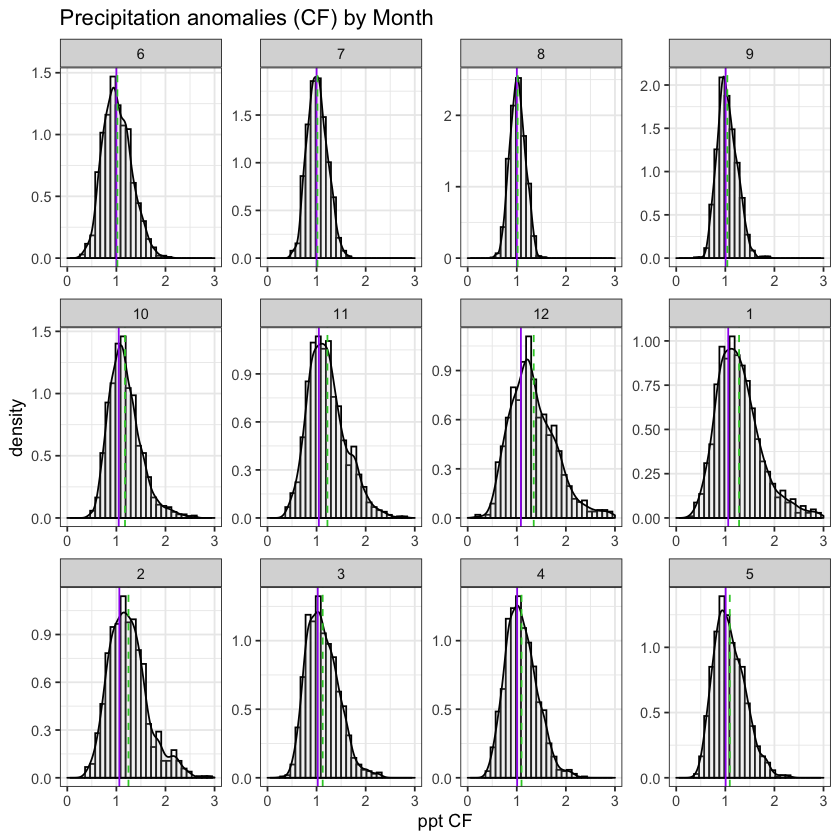

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 866 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 866 rows containing non-finite values (stat_density).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”


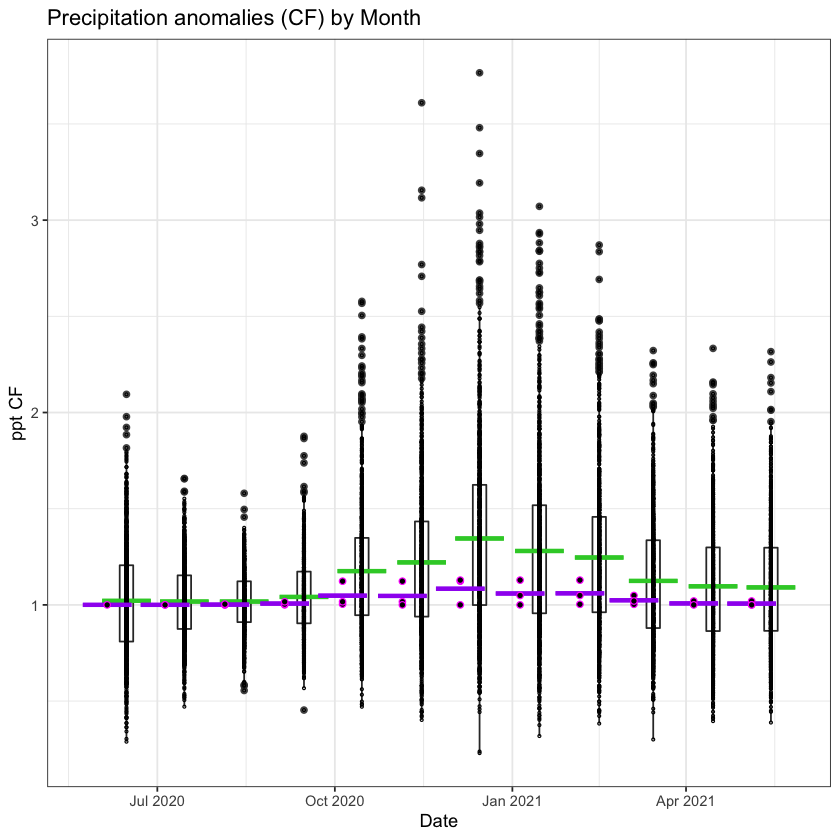

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


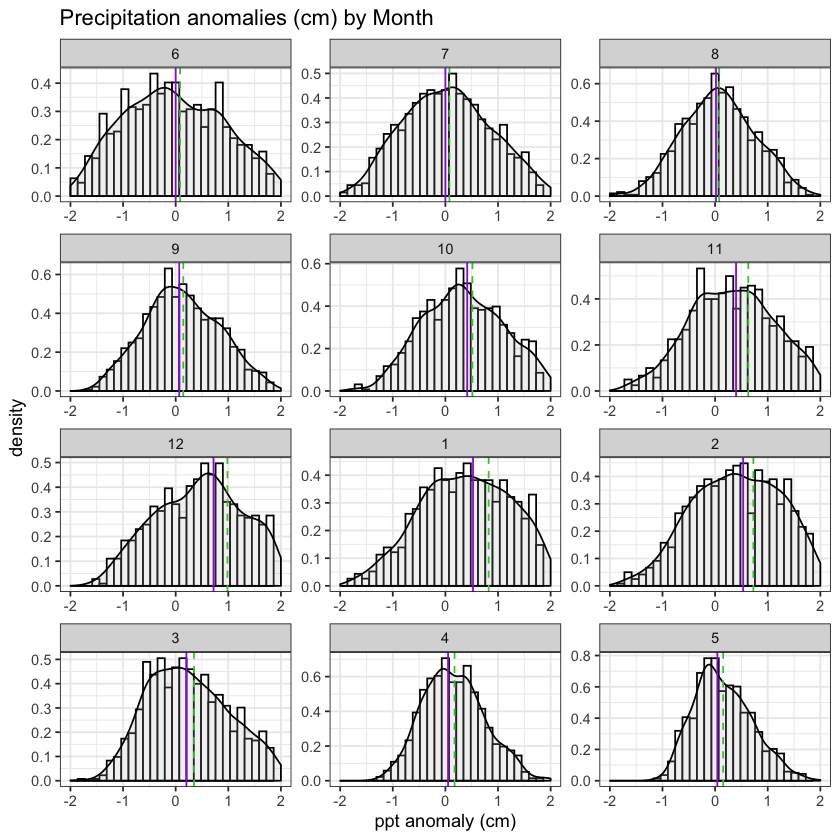

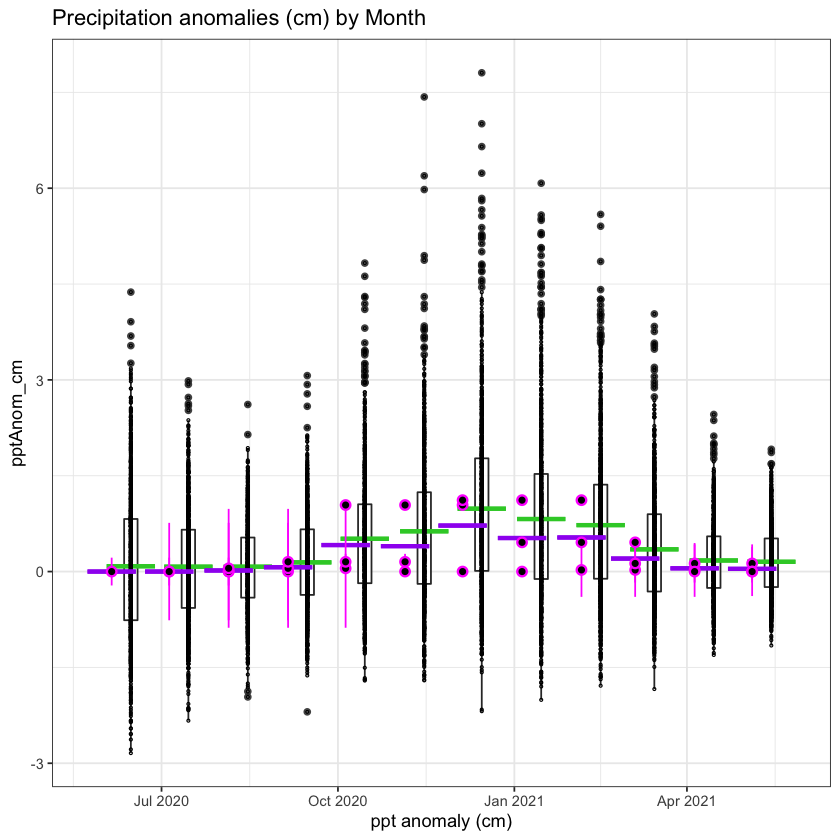

In [26]:
# Plots comparing the distribution of generated anomaly data at the Monthly level
# to NWS values for the same monthly periods

print('Density and box plots of monthly anomalies used in SOILWAT2 vs NWS')

# Correction Factor
NWSMeans <- setDT(NWSAnomsAll2)[,.(meanForecastDiff = mean(Anom_CF)), .(m)]
names(NWSMeans)[1] <- 'Month'

generatedMean <- setDT(MonthlyAnoms2)[,.(meanGenAnom = mean(pptAnom_CF)), .(Month)]
NWSMeans$Month <- factor(NWSMeans$Month, levels = c(6:12, 1:5))
NWSMeans$Year <- c(rep(2021,5), rep(2020, 7))
NWSMeans$Date <- as.Date(paste0(NWSMeans$Year, '-', NWSMeans$Month, '-05'))

# hists
ggplot(MonthlyAnoms2, aes(pptAnom_CF)) +
  geom_histogram(aes(y=..density..), colour="black", fill="white")+
  geom_density(alpha=.2, fill="gray") +
  facet_wrap(~Month, scales = 'free', nrow = 4) +
  labs(title = 'Precipitation anomalies (CF) by Month', x = 'ppt CF') +
  geom_vline(data = NWSMeans, aes(xintercept = meanForecastDiff), color = 'purple') +
  geom_vline(data = generatedMean, aes(xintercept = meanGenAnom), color = 'limegreen', linetype = 'dashed')+
  theme_bw() +
  xlim(0, 3)

# boxplots
ggplot() +
  geom_boxplot(data = MonthlyAnoms2, aes(Date, pptAnom_CF, group = Month), fatten = NULL, width = 7, alpha = 0.8) +
  stat_summary(data = MonthlyAnoms2, aes(Date, pptAnom_CF, group = Month, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'limegreen') +
  geom_point(data = MonthlyAnoms2, aes(Date, pptAnom_CF, group = Month), shape = 21, size =.5, fill = NA) +
  # NWS dots and lines
  stat_summary(data = NWSMeans, aes(Date, meanForecastDiff, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'purple') +
  geom_point(data = NWSAnomsAll2, aes(Date, Anom_CF_MEDIAN), shape = 21, fill = 'black', color = 'magenta') +
    labs(title = 'Precipitation anomalies (CF) by Month', y = 'ppt CF') +

  theme_bw()

###### PPT Anomalies in cm


generatedMean <- setDT(MonthlyAnoms2)[,.(meanGenAnom = mean(pptAnom_cm)), .(Month)]

NWSMeans <- setDT(NWSAnomsAll2)[,.(meanForecastDiff = mean(Anom_cm)), .(m)]
names(NWSMeans)[1] <- 'Month'
NWSMeans$Month <- factor(NWSMeans$Month, levels = c(6:12, 1:5))
NWSMeans$Year <- c(rep(2021,5), rep(2020, 7))
NWSMeans$Date <- as.Date(paste0(NWSMeans$Year, '-', NWSMeans$Month, '-05'))

# hists
ggplot(MonthlyAnoms2, aes(pptAnom_cm)) +
  geom_histogram(aes(y=..density..), colour="black", fill="white")+
  geom_density(alpha=.2, fill="gray") +
  facet_wrap(~Month, scales = 'free', nrow = 4) +
  labs(title = 'Precipitation anomalies (cm) by Month', x = 'ppt anomaly (cm)') +
  geom_vline(data = NWSMeans, aes(xintercept = meanForecastDiff), color = 'purple') +
  geom_vline(data = generatedMean, aes(xintercept = meanGenAnom), color = 'limegreen', linetype = 'dashed')+
  theme_bw() +
  xlim(-2, 2)

# boxplots
ggplot() +
  geom_boxplot(data = MonthlyAnoms2, aes(Date, pptAnom_cm, group = Month), fatten = NULL, width = 7, alpha = 0.8) +
  stat_summary(data = MonthlyAnoms2, aes(Date, pptAnom_cm, group = Month, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'limegreen') +
  geom_point(data = MonthlyAnoms2, aes(Date, pptAnom_cm, group = Month), shape = 21, size =.5, fill = NA) +
  # NWS dots and lines
  stat_summary(data = NWSMeans, aes(Date, meanForecastDiff, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'purple') +
  geom_pointrange(data = NWSAnomsAll2, aes(Date, Anom_cm,
                                           ymin = Anom_cm - ForecastedSD_PPT_cm,
                                           ymax = Anom_cm + ForecastedSD_PPT_cm), shape = 21, fill = 'black', color = 'magenta') +
  labs(title = 'Precipitation anomalies (cm) by Month', x = 'ppt anomaly (cm)') +
  
theme_bw()





Next, three-year long SOILWAT2 simulations are run using this data. First year is observed data for spin up , second year is part observed and the future, third year is the rest of the future and then dummy data after today's date + 12 months. The anomalies are applied to each year in the historical record for each future (i.e. 30 years). EAch year is run individually so therre is proper spin up and not confound the accumulation of certain conditions and represent the range of possible conditions at the site. This entire process is repeated 30 times, resulting in 900 years.

# Downscaling Results




In [35]:
### Tempererature time series - 18 month period - absolutes and differrences

Warning message:
“Ignoring unknown aesthetics: y”
Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”


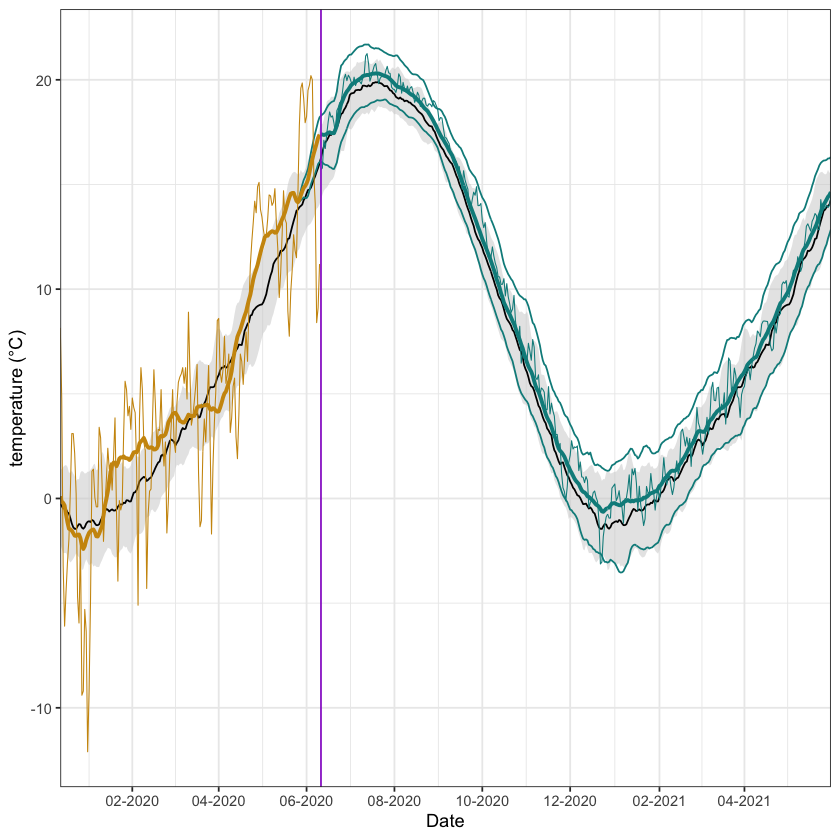

Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning messag

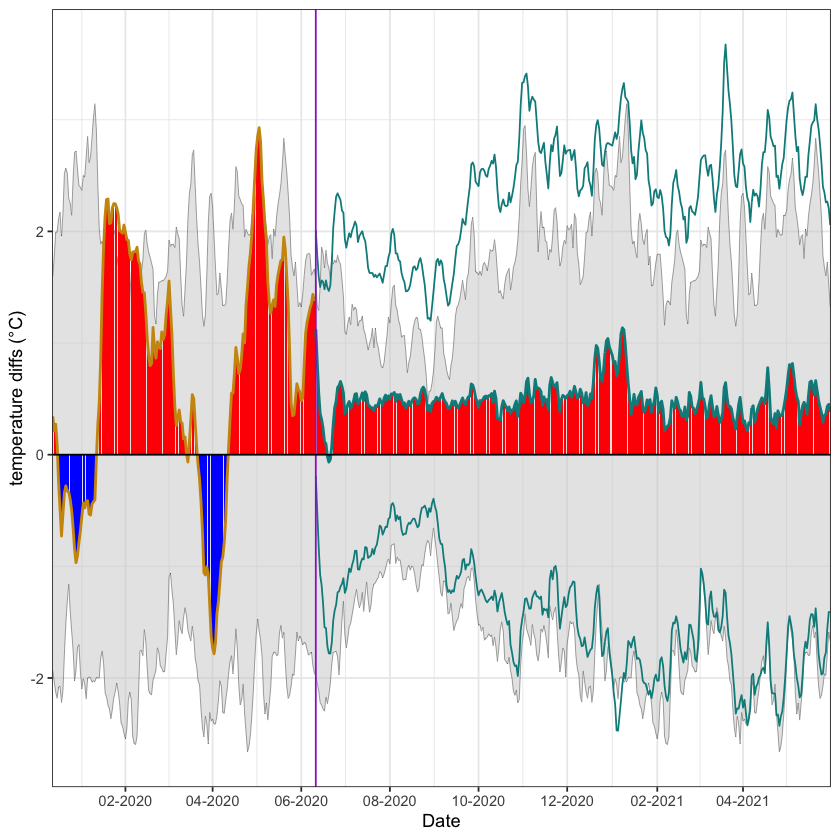

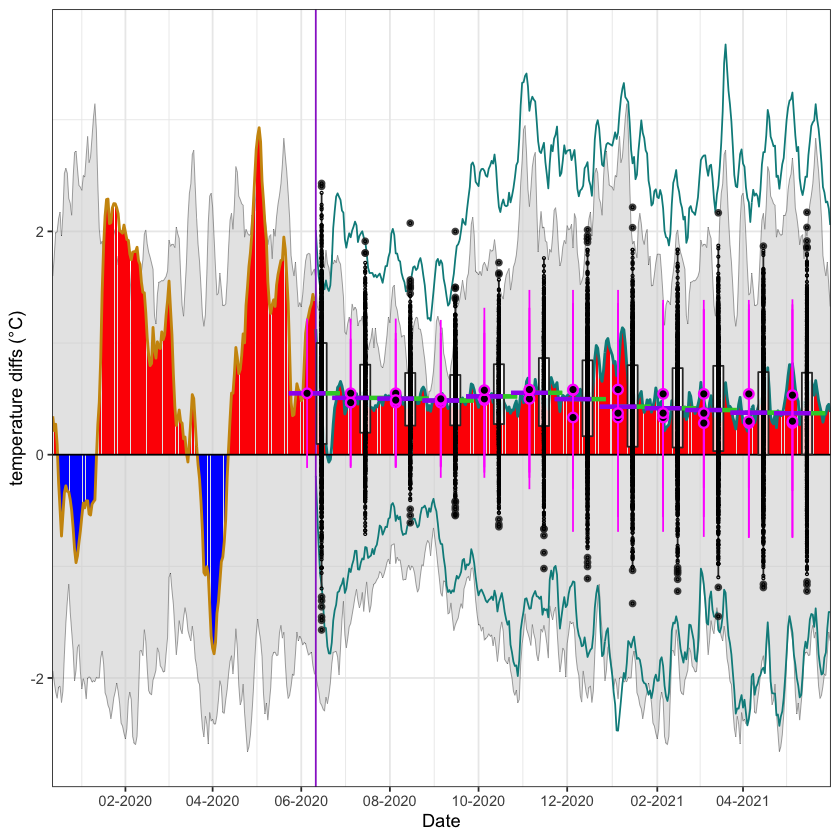

In [36]:
####### This is a lot of code!
source('figureCode/presentationFigs/FigureDataPrep.R')
source('figureCode/presentationFigs/Temperature.R')


Warning message:
“Ignoring unknown aesthetics: y”
Warning message:
“Removed 355 rows containing missing values (position_stack).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”


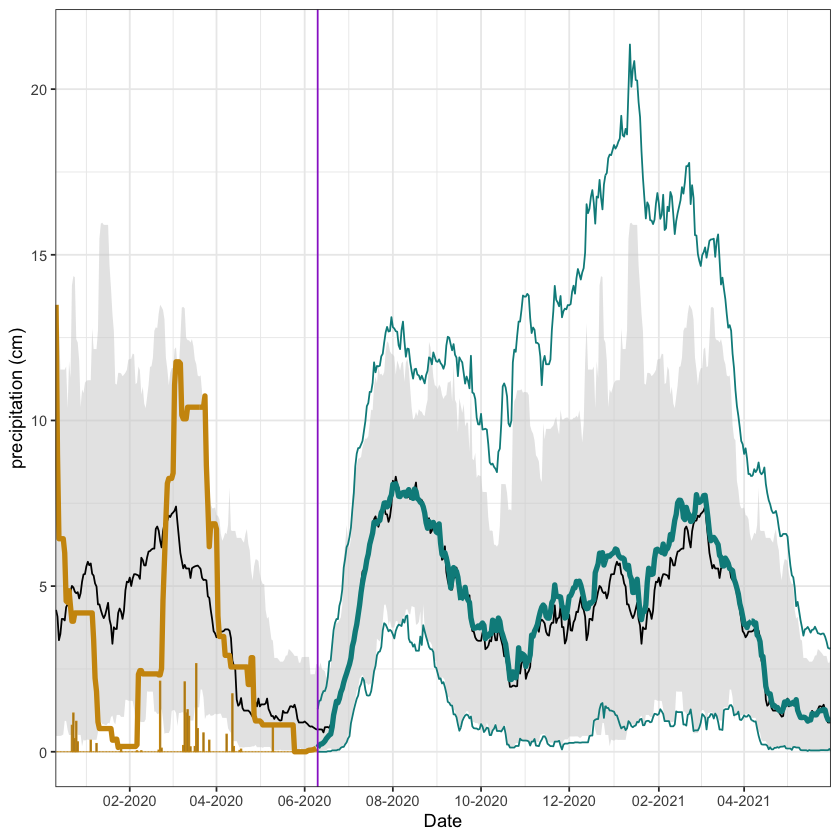

Warning message:
“Computation failed in `stat_summary()`:
'what' must be a function or character string”
Warning message:
“Computation failed in `stat_summary()`:
'what' must be a function or character string”
Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows

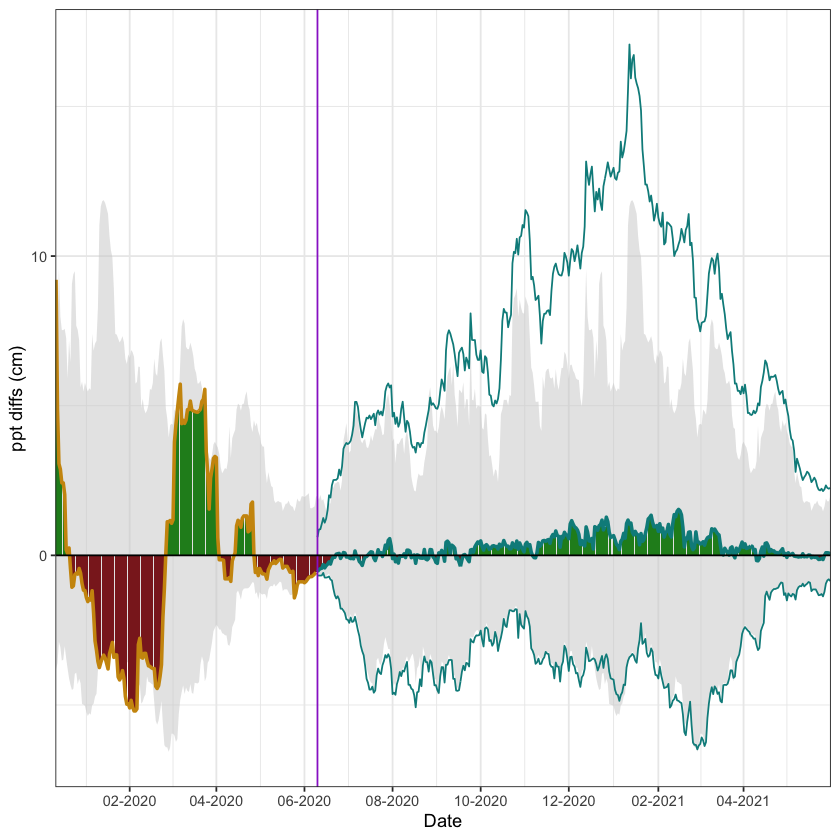

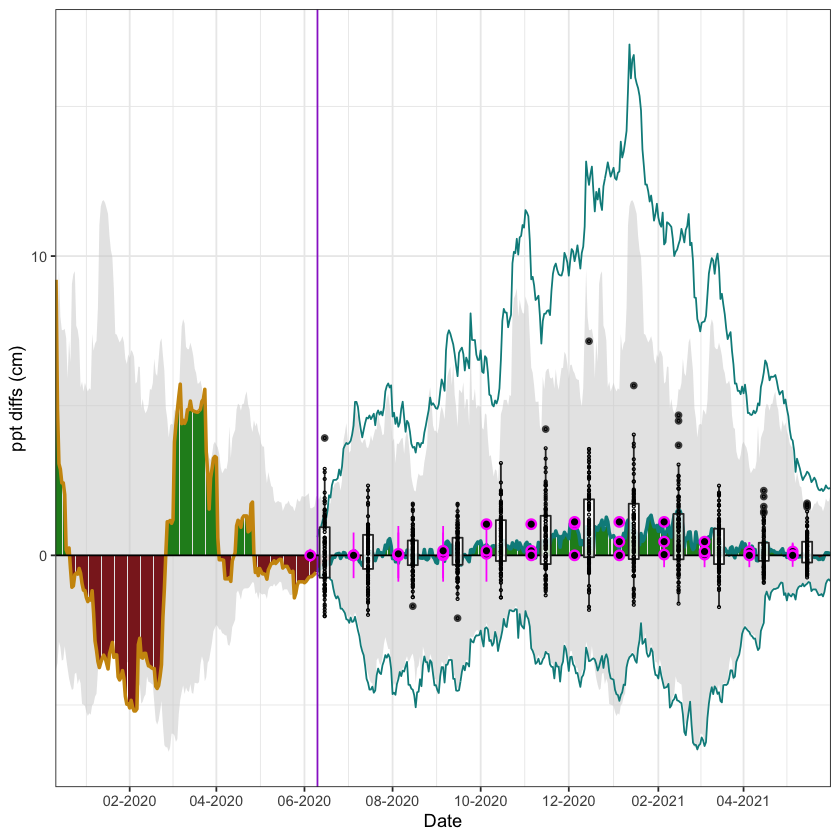

In [69]:
source('figureCode/presentationFigs/precipitation.R')